In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, mean_squared_error
from typing import List, Dict
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
main_df = pd.read_csv("train.csv")
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)


### **splitting the data to train and validation**

In [3]:
main_df_train_initial, main_df_val_initial = train_test_split(main_df, test_size=0.2, random_state=42)
df_train=main_df_train_initial.copy() #copy of train
print(f'Our training data shape is: {df_train.shape}')
df_train.head()



Our training data shape is: (44369, 17)


ID worked_in_the_past age_group disability     is_dev education  \
3843   14125                  T       old         No  developer    MA/MSc   
52884  62021                  T       old         No  developer     other   
13649  68144                  T     young        Yes  developer    BA/BSc   
33106  61818                  T     young         No  developer    BA/BSc   
14492  64833                  T     young         No        NaN    BA/BSc   

        sex mental_issues  years_of_experience          A     B    C  \
3843   Male            No                 10.0   0.189733  15.0   aa   
52884  Male           Yes                 13.0   4.232576  11.0  rhz   
13649  Male           Yes                 12.0 -10.623775   9.0   aa   
33106  Male            No                  9.0  -1.629383   NaN   ww   
14492  Male            No                 13.0   5.247467   8.0   ww   

                D                   country  prev_salary  \
3843   181.089420  United States of America     100000.0   
52884  179.399237  United States of America     165000.0   
13649  179.272213                   Germany      63986.0   
33106  180.369400  United States of America     110000.0   
14492  180.138460                       NaN     105414.0   

                                        stack_experience  label  
3843   C;C++;Java;Python;Chef;Deno;Angular;jQuery;Sve...      0  
52884                                                NaN      1  
13649                          Java;Kotlin;Flow;Homebrew      0  
33106  Go;JavaScript;SQL;TypeScript;Docker;npm;Node.j...      1  
14492                                                NaN      1

### **Removing Rows That May Introduce Bias**

In this code, we focused on cleaning the data by removing rows with many missing values (NULLs). We started by testing thresholds of 6, 5, 4, and finally settled on a threshold of 3. If a row contained 3 or more missing values (excluding the label column), it was removed from the DataFrame. Each time we lowered the threshold, the AUC (Area Under the Curve) score slightly increased, indicating incremental improvements in model performance. Ultimately, this cleaning process helped refine our data for better predictive accuracy.

In [4]:
def remove_rows_with_many_nulls(df):
    label_column = 'label'  # Specify the label column if it's different
    threshold = 3 # Number of nulls threshold
    rows_to_remove = []

    # Iterate over the DataFrame rows
    for index, row in df.drop(columns=[label_column]).iterrows():
        # Count nulls in the current row
        if row.isnull().sum() >= threshold:
            rows_to_remove.append(index)

    # Print the number of rows to be removed
    print(f"Number of rows to be removed: {len(rows_to_remove)}")

    # Remove the rows from the DataFrame
    cleaned_df = df.drop(index=rows_to_remove)

    return cleaned_df




In [5]:

df_train = remove_rows_with_many_nulls(df_train)
print(f'Our training data shape after clean is: {df_train.shape}')
df_train.head()

Number of rows to be removed: 2504
Our training data shape after clean is: (41865, 17)


ID worked_in_the_past age_group disability     is_dev education  \
3843   14125                  T       old         No  developer    MA/MSc   
52884  62021                  T       old         No  developer     other   
13649  68144                  T     young        Yes  developer    BA/BSc   
33106  61818                  T     young         No  developer    BA/BSc   
10242  72357                  T       old         No  developer    BA/BSc   

        sex mental_issues  years_of_experience          A     B    C  \
3843   Male            No                 10.0   0.189733  15.0   aa   
52884  Male           Yes                 13.0   4.232576  11.0  rhz   
13649  Male           Yes                 12.0 -10.623775   9.0   aa   
33106  Male            No                  9.0  -1.629383   NaN   ww   
10242  Male            No                 15.0   1.952668  10.0   hr   

                D                   country  prev_salary  \
3843   181.089420  United States of America     100000.0   
52884  179.399237  United States of America     165000.0   
13649  179.272213                   Germany      63986.0   
33106  180.369400  United States of America     110000.0   
10242  180.348724                 Australia      70771.0   

                                        stack_experience  label  
3843   C;C++;Java;Python;Chef;Deno;Angular;jQuery;Sve...      0  
52884                                                NaN      1  
13649                          Java;Kotlin;Flow;Homebrew      0  
33106  Go;JavaScript;SQL;TypeScript;Docker;npm;Node.j...      1  
10242  Bash/Shell;HTML/CSS;JavaScript;PHP;SQL;Docker;...      0

In [6]:
unique_values = df_train['label'].unique()
print(unique_values)

[0 1]


# **Part 1- Exploration & Part 2 - Data Processing**

In [7]:
print(f'Our training data shape is: {df_train.shape}')
print(f'{df_train.shape[1]-1} features and 1 target')

Our training data shape is: (41865, 17)
16 features and 1 target


In [8]:
df_train.dtypes

ID                       int64
worked_in_the_past      object
age_group               object
disability              object
is_dev                  object
education               object
sex                     object
mental_issues           object
years_of_experience    float64
A                      float64
B                      float64
C                       object
D                      float64
country                 object
prev_salary            float64
stack_experience        object
label                    int64
dtype: object

In [9]:
#finding how many unique values are in catagorial columns
cols=['C','worked_in_the_past','age_group','disability','is_dev','education','sex','mental_issues','country','stack_experience']
for col in cols:
    print(f'Number of unique values in {col}: {df_train[col].nunique()}')

Number of unique values in C: 7
Number of unique values in worked_in_the_past: 2
Number of unique values in age_group: 2
Number of unique values in disability: 2
Number of unique values in is_dev: 2
Number of unique values in education: 5
Number of unique values in sex: 3
Number of unique values in mental_issues: 2
Number of unique values in country: 164
Number of unique values in stack_experience: 31128


**before ploting the data we assume from the feature explanation that some of the features need to be treat before the visualizing step:**



## **handle with catagorical Features:**

### **"c", "education", "stack experience", "sex", "country"**

### **'c' exploring :**

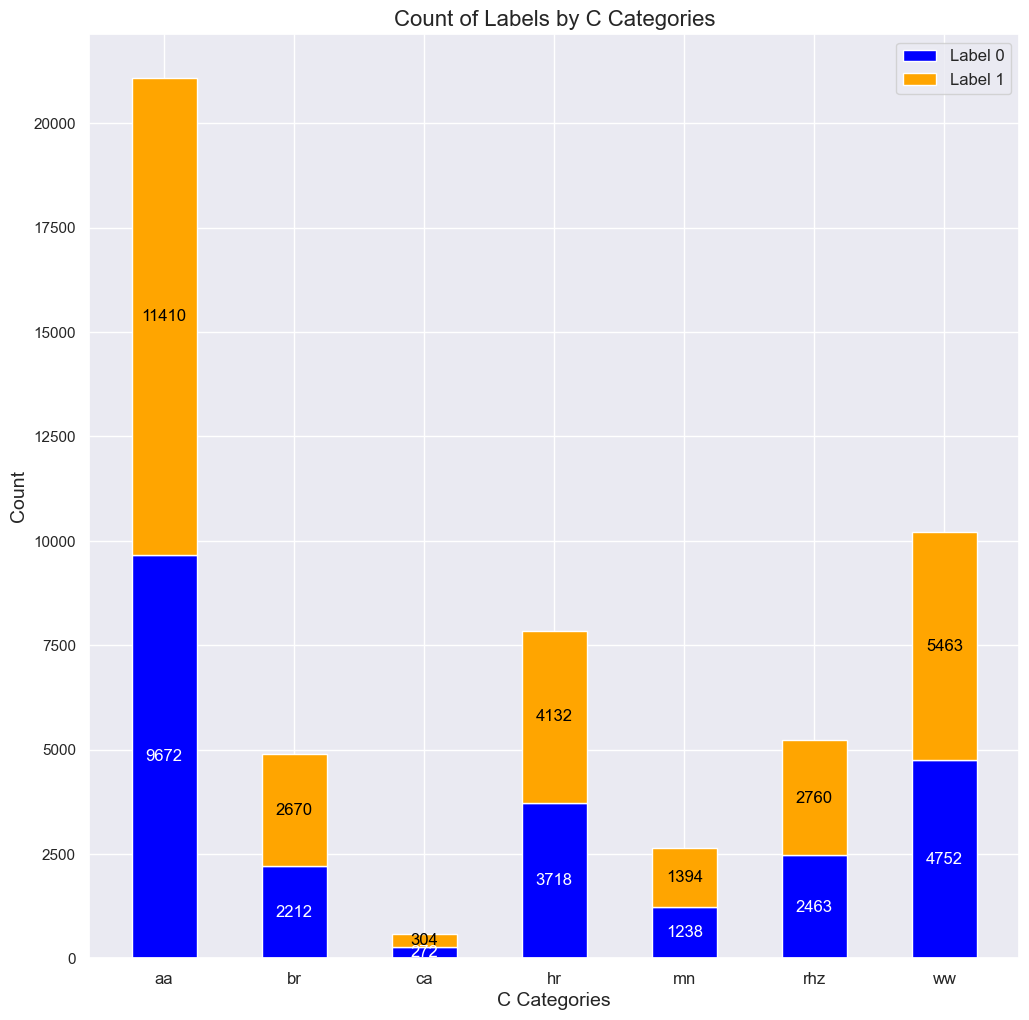

In [10]:
grouped_data = main_df.groupby(['C', 'label']).size().unstack()
plt.figure(figsize=(12, 12))
colors = ['blue', 'orange']
num_categories = len(grouped_data)
bar_width = 0.5
bar_positions = np.arange(num_categories)
plt.bar(bar_positions, grouped_data[0], color=colors[0], width=bar_width, label='Label 0')
plt.bar(bar_positions, grouped_data[1], color=colors[1], width=bar_width, bottom=grouped_data[0], label='Label 1')
plt.xticks(bar_positions, grouped_data.index)
plt.xticks(bar_positions, grouped_data.index, fontsize=12)
plt.xlabel('C Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Labels by C Categories', fontsize=16)
plt.legend(fontsize=12)

# Increase the gap between count numbers
label_0 = 0.15
label_1_ = 0.3

# Add numbers for label 0
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] / 2, f'{grouped_data.iloc[i, 0]}', ha='center', va='center', color='white')

# Add numbers for label 1
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] + grouped_data.iloc[i, 1] / 2, f'{grouped_data.iloc[i, 1]}', ha='center', va='center', color='black')

plt.show()


**Distribution Across Categories:**

Data visualization was created to understand how two labels (Label 0 and Label 1) are distributed across different categories (such as "aa," "br," "ca," etc.) within a feature called "C."

Label distribution analysis was conducted to see if certain categories tend to have more of one label than the other.

Insights and implications were suggested regarding the significance of these categories and how they might impact further data analysis.

Results:

The categories "aa" and "ww" are the most common and therefore important for analysis. Categories with smaller data counts (like "cz" and "mm") might require special handling in analysis or modeling.
The label distribution in the main categories is relatively balanced, indicating no strong preference for one label over the other in these categories.

**Feature Engineering**: Based on these findings, we proceed to use One Hot Encoding to transform the categorical data, ensuring that our model can effectively utilize the information from these categories.
before process we will drop 'c' feature.

### **'country'- exploring:**




country - according to the big amount of the origin countries we define a dictionary country_to_continent that maps countries to their respective continents. It then uses this dictionary to replace the country names in the 'country' column of the DataFrame df with the corresponding continent names. this will decrease the amount and keep suitable meaning to future analysis (We will check the validity using a Chi-Square test). before process we will drop 'country' feature.

In [11]:
country_to_continent = {
    'United States of America': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Brazil': 'South America', 'Argentina': 'South America', 'Uruguay': 'South America',
    'France': 'Europe', 'Germany': 'Europe', 'Spain': 'Europe', 'Italy': 'Europe', 'Latvia': 'Europe',
    'United Kingdom of Great Britain and Northern Ireland': 'Europe', 'Slovakia': 'Europe', 'Czech Republic': 'Europe',
    'Romania': 'Europe', 'Denmark': 'Europe', 'Norway': 'Europe', 'Austria': 'Europe', 'Netherlands': 'Europe',
    'Finland': 'Europe', 'Poland': 'Europe', 'Lithuania': 'Europe', 'Croatia': 'Europe', 'Belgium': 'Europe',
    'Hungary': 'Europe', 'Estonia': 'Europe', 'Sweden': 'Europe', 'Portugal': 'Europe', 'Greece': 'Europe',
    'Ireland': 'Europe', 'Ukraine': 'Europe', 'Iceland': 'Europe', 'Belarus': 'Europe', 'Bulgaria': 'Europe',
    'Luxembourg': 'Europe', 'Bosnia and Herzegovina': 'Europe', 'Albania': 'Europe', 'Georgia': 'Europe',
    'Slovenia': 'Europe', 'Serbia': 'Europe', 'The former Yugoslav Republic of Macedonia': 'Europe',
    'Montenegro': 'Europe', 'Malta': 'Europe', 'Monaco': 'Europe', 'Andorra': 'Europe',
    'Australia': 'Australia', 'New Zealand': 'Australia', 'Fiji': 'Australia',
    'South Africa': 'Africa', 'Ethiopia': 'Africa', 'Kenya': 'Africa', 'Ghana': 'Africa',
    'Nigeria': 'Africa', 'Egypt': 'Africa', 'Morocco': 'Africa', 'Madagascar': 'Africa', 'Tunisia': 'Africa',
    'Senegal': 'Africa', 'Uganda': 'Africa', 'Sudan': 'Africa', 'United Republic of Tanzania': 'Africa',
    'Zambia': 'Africa', 'Congo, Republic of the...': 'Africa', 'Mozambique': 'Africa', 'Angola': 'Africa',
    'Algeria': 'Africa', 'Somalia': 'Africa', 'Cape Verde': 'Africa', 'Swaziland': 'Africa', 'Libyan Arab Jamahiriya': 'Africa',
    'Malawi': 'Africa', 'Namibia': 'Africa', 'Guinea': 'Africa', 'Mauritania': 'Africa', 'Botswana': 'Africa',
    'Togo': 'Africa', 'Gambia': 'Africa', 'Burkina Faso': 'Africa', 'Rwanda': 'Africa', 'Zimbabwe': 'Africa',
    'Cameroon': 'Africa', 'Democratic Republic of the Congo': 'Africa', 'Haiti': 'Africa', 'Niger': 'Africa',
    'Mali': 'Africa', 'Libya': 'Africa',
    'China': 'Asia', 'India': 'Asia', 'Israel': 'Asia', 'Russian Federation': 'Asia', 'Turkey': 'Asia',
    'Malaysia': 'Asia', 'Japan': 'Asia', 'Taiwan': 'Asia', 'Nepal': 'Asia', 'Bangladesh': 'Asia',
    'Kazakhstan': 'Asia', 'Philippines': 'Asia', 'Sri Lanka': 'Asia', 'Viet Nam': 'Asia', 'Pakistan': 'Asia',
    'Thailand': 'Asia', 'Armenia': 'Asia', 'Indonesia': 'Asia', 'Saudi Arabia': 'Asia', 'Palestine': 'Asia',
    'Uzbekistan': 'Asia', 'Singapore': 'Asia', 'South Korea': 'Asia', 'Lebanon': 'Asia', 'Myanmar': 'Asia',
    'Iran, Islamic Republic of...': 'Asia', 'Syrian Arab Republic': 'Asia', 'Jordan': 'Asia', 'Kuwait': 'Asia',
    'Maldives': 'Asia', 'Barbados': 'Asia', 'Azerbaijan': 'Asia', 'United Arab Emirates': 'Asia', 'Iraq': 'Asia',
    'Afghanistan': 'Asia', 'Yemen': 'Asia', 'Oman': 'Asia', 'Qatar': 'Asia', 'Cyprus': 'Asia', 'Bahrain': 'Asia',
    'Turkmenistan': 'Asia', 'Tajikistan': 'Asia', 'Kyrgyzstan': 'Asia', 'Armenia': 'Asia', 'Bhutan': 'Asia',
    'Timor-Leste': 'Asia', "Lao People's Democratic Republic": 'Asia'}


def categorical_cols_handle(df, train):
    # Map countries to continents
    df['country_to_continent'] = df['country'].map(country_to_continent)

    # Save the ID column in a variable
    if 'ID' in df.columns:
        Candidate_ID = df['ID']
    else:
        raise KeyError("Column 'ID' not found in the DataFrame.")

    # Drop 'country' and 'ID' columns
    if 'country' in df.columns:
        df.drop('country', axis=1, inplace=True)
    else:
        raise KeyError("Column 'country' not found in the DataFrame.")

    if 'ID' in df.columns:
        df.drop('ID', axis=1, inplace=True)
    else:
        raise KeyError("Column 'ID' not found in the DataFrame.")

    # Move the label column to the end if we are in the training phase
    if train:
        if 'label' in df.columns:
            label = df.pop('label')
            df['label'] = label
        else:
            raise KeyError("Column 'label' not found in the DataFrame.")

    return df, Candidate_ID


In [12]:
df_train, _ = categorical_cols_handle(df_train,True)
df_train.head()

worked_in_the_past age_group disability     is_dev education   sex  \
3843                   T       old         No  developer    MA/MSc  Male   
52884                  T       old         No  developer     other  Male   
13649                  T     young        Yes  developer    BA/BSc  Male   
33106                  T     young         No  developer    BA/BSc  Male   
10242                  T       old         No  developer    BA/BSc  Male   

      mental_issues  years_of_experience          A     B    C           D  \
3843             No                 10.0   0.189733  15.0   aa  181.089420   
52884           Yes                 13.0   4.232576  11.0  rhz  179.399237   
13649           Yes                 12.0 -10.623775   9.0   aa  179.272213   
33106            No                  9.0  -1.629383   NaN   ww  180.369400   
10242            No                 15.0   1.952668  10.0   hr  180.348724   

       prev_salary                                   stack_experience  \
3843      100000.0  C;C++;Java;Python;Chef;Deno;Angular;jQuery;Sve...   
52884     165000.0                                                NaN   
13649      63986.0                          Java;Kotlin;Flow;Homebrew   
33106     110000.0  Go;JavaScript;SQL;TypeScript;Docker;npm;Node.j...   
10242      70771.0  Bash/Shell;HTML/CSS;JavaScript;PHP;SQL;Docker;...   

      country_to_continent  label  
3843         North America      0  
52884        North America      1  
13649               Europe      0  
33106        North America      1  
10242            Australia      0

In [13]:
print(df_train.columns)
df_train.columns = df_train.columns.str.strip()


Index(['worked_in_the_past', 'age_group', 'disability', 'is_dev', 'education',
       'sex', 'mental_issues', 'years_of_experience', 'A', 'B', 'C', 'D',
       'prev_salary', 'stack_experience', 'country_to_continent', 'label'],
      dtype='object')


In [14]:

df_train.columns = df_train.columns.str.strip()
continent_counts = df_train.groupby('country_to_continent')['label'].value_counts(normalize=True).unstack()
continent_percentage = continent_counts * 100
print(continent_percentage)


label                         0          1
country_to_continent                      
Africa                36.688617  63.311383
Asia                  47.116516  52.883484
Australia             42.685026  57.314974
Europe                47.764500  52.235500
North America         45.574781  54.425219
South America         45.502092  54.497908


**Chi-Square Test:**

The Chi-Square test is a statistical method used to determine if there is a significant association between two categorical variables. In our analysis, we applied this test to check the relationship between the country_to_continent feature and the labels (Label 1 and Label 0).

label                    0     1
country_to_continent            
Africa                 390   673
Asia                  3603  4044
Australia              496   666
Europe                8194  8961
North America         4583  5473
South America          870  1042


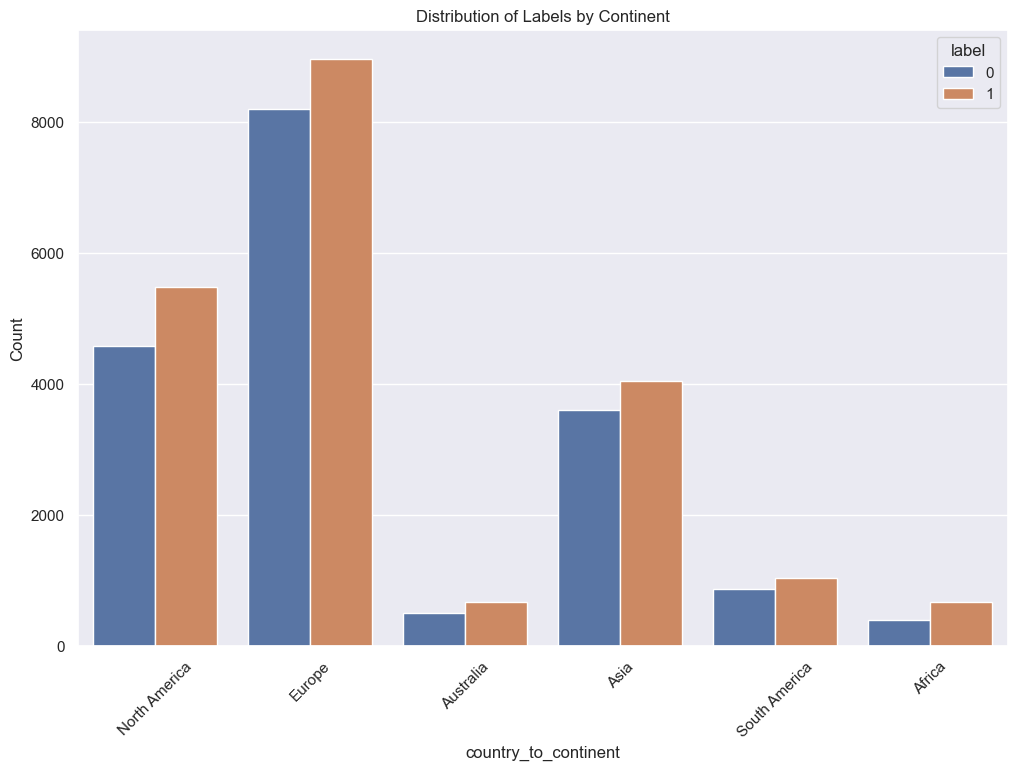

Chi-Square Statistic: 64.34806806867657
p-value: 1.5300384039635493e-12
There is a significant correlation between continent and label.


In [15]:

# יצירת טבלת שכיחות
continent_label_crosstab = pd.crosstab(df_train['country_to_continent'], df_train['label'])
print(continent_label_crosstab)

# גרף עמודות להתפלגות התוויות לפי יבשות
plt.figure(figsize=(12, 8))
sns.countplot(x='country_to_continent', hue='label', data=df_train)
plt.title('Distribution of Labels by Continent')
plt.xlabel('country_to_continent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# ביצוע מבחן כי-בריבוע
chi2, p, dof, expected = chi2_contingency(continent_label_crosstab)

print(f'Chi-Square Statistic: {chi2}')
print(f'p-value: {p}')

# אם ה-p-value קטן מ-0.05, יש תלות מובהקת סטטיסטית בין היבשות לתוויות
if p < 0.05:
    print('There is a significant correlation between continent and label.')
else:
    print('There is no significant correlation between continent and label.')

**Conclusion from Chi-Square test:**

While the test indicated a statistically significant association (p< 0.05) , it's important to note that the actual distribution of labels across the continents appears quite similar. we assumed that the significance may be driven by small differences amplified by the large sample size, rather than meaningful differences in label distribution.from the diagram you can see that in Africa more nominate got 1 than 0 but there are not a lot of nominates.

To account for this, we encoded the country_to_continent feature by mapping the mean of the target variable (label) for each continent into a new continent_encoded feature. This encoding helps to preserve relevant information while simplifying the feature.

We will assess the impact of this encoding in further analysis to determine whether it truly improves our model's performance, or if the observed statistical significance lacks practical relevance.

**encoding 'c' and 'country'**

1. according to the  'c' exploring we will do encoding with one-hot encoding before process we will drop 'c' feature

2. To encode the country_to_continent feature while preserving the correlation with the label, we used mean encoding. This technique assigns a numeric value to each category based on the average value of the target variable for that category - from in order to
Africa :               0.63311383
Asia    :              0.52883484
Australia  :           0.57314974
Europe   :             0.52235500
North America:         0.54425219
South America  :       0.54497908

In [16]:

def encode_catagorial_cols(df, train, continent_means=None):
    # Using one-hot encoding for 'C'
    df = pd.get_dummies(df, columns=['C'], drop_first=True)

    # Changing every True in the data to 1 and False to 0
    df = df.replace({True: 1, False: 0})

    # For training data, calculate the mean of the target variable (label) for each category in 'country_to_continent'
    if train:
        continent_means = df.groupby('country_to_continent')['label'].mean()

    # Map the means to the original dataframe
    df['continent_encoded'] = df['country_to_continent'].map(continent_means)

    # Drop 'country_to_continent' because we have the encoded column
    df.drop(['country_to_continent'], axis=1, inplace=True)

    # Move the label column to the end if training
    if train and 'label' in df.columns:
        label = df.pop('label')
        df['label'] = label

    return df, continent_means


In [17]:
#df_train = encode_catagorial_cols(df_train, True)
df_train, continent_means = encode_catagorial_cols(df_train, train=True)

df_train.head()

worked_in_the_past age_group disability     is_dev education   sex  \
3843                   T       old         No  developer    MA/MSc  Male   
52884                  T       old         No  developer     other  Male   
13649                  T     young        Yes  developer    BA/BSc  Male   
33106                  T     young         No  developer    BA/BSc  Male   
10242                  T       old         No  developer    BA/BSc  Male   

      mental_issues  years_of_experience          A     B           D  \
3843             No                 10.0   0.189733  15.0  181.089420   
52884           Yes                 13.0   4.232576  11.0  179.399237   
13649           Yes                 12.0 -10.623775   9.0  179.272213   
33106            No                  9.0  -1.629383   NaN  180.369400   
10242            No                 15.0   1.952668  10.0  180.348724   

       prev_salary                                   stack_experience  C_br  \
3843      100000.0  C;C++;Java;Python;Chef;Deno;Angular;jQuery;Sve...     0   
52884     165000.0                                                NaN     0   
13649      63986.0                          Java;Kotlin;Flow;Homebrew     0   
33106     110000.0  Go;JavaScript;SQL;TypeScript;Docker;npm;Node.j...     0   
10242      70771.0  Bash/Shell;HTML/CSS;JavaScript;PHP;SQL;Docker;...     0   

       C_ca  C_hr  C_mn  C_rhz  C_ww  continent_encoded  label  
3843      0     0     0      0     0           0.544252      0  
52884     0     0     0      1     0           0.544252      1  
13649     0     0     0      0     0           0.522355      0  
33106     0     0     0      0     1           0.544252      1  
10242     0     1     0      0     0           0.573150      0

In [18]:
unique_values = df_train['continent_encoded'].unique()
print(unique_values)


[0.54425219 0.522355   0.57314974        nan 0.52883484 0.54497908
 0.63311383]


# **stack experience and education:**


1. stack_experience - At first, we considered encoding the stack experience based on the number of technologies each candidate listed. However, this approach was not accurate, as some programming languages are more important in the industry today than others. We wanted to ensure that we didn't lose this valuable feature, so we decided to assign scores to the technologies.Programming languages that are highly ranked in the industry were given a score of 10, while niche languages received a score of 5. Other technologies were assigned a score of 1. This approach allowed us to account not only for the length of the stack experience string but also for its quality, which can significantly influence a candidate's chances of getting hired.



2. education - The 'education' feature represents an ordinal variable where the categories have a meaningful order. Encoding the levels as increasing integers preserves this order. the 'other' catagory because we dont know what is meaning we assign 'other' a separate ordinal value (-1)(maybe higher education, combination, or even none.

In [19]:
# Define the list with the order of educational levels
education_ord = ['High school', 'BA/BSc', 'MA/MSc', 'Phd']
# Dictionary of scores
scores = {
    "APL": 6,
    "Assembly": 6,
    "Bash/Shell": 6,
    "C": 7,
    "C#": 9,
    "C++": 9,
    "Clojure": 6,
    "COBOL": 5,
    "Crystal": 6,
    "Dart": 5,
    "Delphi": 6,
    "Elixir": 6,
    "Erlang": 6,
    "F#": 6,
    "Fortran": 5,
    "Go": 6,
    "Groovy": 6,
    "Haskell": 5,
    "HTML/CSS": 6,
    "Java": 10,
    "JavaScript": 10,
    "Julia": 5,
    "Kotlin": 6,
    "LISP": 5,
    "Lua": 5,
    "MATLAB": 7,
    "OCaml": 6,
    "Objective-C": 9,
    "Perl": 9,
    "PHP-VBA": 5,
    "PowerShell": 7,
    "Python": 10,
    "R": 6,
    "Ruby": 9,
    "Rust": 5,
    "SAS": 6,
    "Scala": 8,
    "Solidity": 6,
    "SQL": 10,
    "Swift": 7,
    "TypeScript": 5
}


def calculate_score(experience_list, score_dict):
    if experience_list is None or experience_list == 'nan':  
        return np.nan  
    score = 0
    for tech in experience_list:
        if tech not in score_dict.keys():
            score += 3
        else:
            score += score_dict[tech]
    return score
def numeric_cols_handle(df):
    
    if 'education' in df.columns:
        df['education'] = df['education'].apply(lambda x: -1 if x == 'other' else education_ord.index(x) if x in education_ord else None)
    else:
        print("Column 'education' not found in the DataFrame.")

    
    if 'stack_experience' in df.columns:
        df['stack_experience'] = df['stack_experience'].apply(lambda x: calculate_score(str(x).split(";") if pd.notna(x) else None, scores))
    else:
        print("Column 'stack_experience' not found in the DataFrame.")

    return df

In [20]:
df_train = numeric_cols_handle(df_train)
df_train.head()

worked_in_the_past age_group disability     is_dev  education   sex  \
3843                   T       old         No  developer        2.0  Male   
52884                  T       old         No  developer       -1.0  Male   
13649                  T     young        Yes  developer        1.0  Male   
33106                  T     young         No  developer        1.0  Male   
10242                  T       old         No  developer        1.0  Male   

      mental_issues  years_of_experience          A     B           D  \
3843             No                 10.0   0.189733  15.0  181.089420   
52884           Yes                 13.0   4.232576  11.0  179.399237   
13649           Yes                 12.0 -10.623775   9.0  179.272213   
33106            No                  9.0  -1.629383   NaN  180.369400   
10242            No                 15.0   1.952668  10.0  180.348724   

       prev_salary  stack_experience  C_br  C_ca  C_hr  C_mn  C_rhz  C_ww  \
3843      100000.0              66.0     0     0     0     0      0     0   
52884     165000.0               NaN     0     0     0     0      1     0   
13649      63986.0              22.0     0     0     0     0      0     0   
33106     110000.0              58.0     0     0     0     0      0     1   
10242      70771.0              59.0     0     0     1     0      0     0   

       continent_encoded  label  
3843            0.544252      0  
52884           0.544252      1  
13649           0.522355      0  
33106           0.544252      1  
10242           0.573150      0

# **"sex" and booleen featurs:**


1. convert the catagories into 0/1 according to the mapping below.
2. sex - because of the little amount of other and female together in relate to male amount we merge the catagories and made it an boleen feature for convinience.

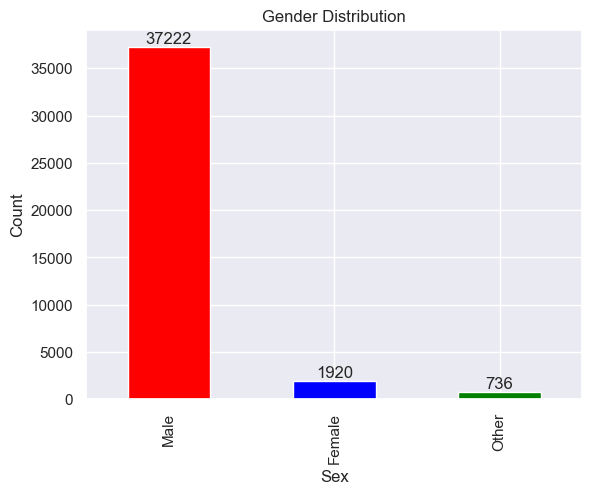

In [21]:


df_train['sex'].value_counts().plot.bar(color=['red', 'blue', 'green'])


sex_counts = df_train['sex'].value_counts()
for i in range(len(sex_counts)):
    plt.text(i, sex_counts[i] + 100, str(sex_counts[i]), ha='center', va='bottom')


plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

In [22]:
def boolean_cols_handle(df):
    if 'sex' in df.columns:
        df['sex'] = df['sex'].replace('Other', 'Female')  # Unite 'Other' and 'Female'

    # Handle boolean columns with specific mappings
    boolean_cols = ['disability', 'sex', 'age_group', 'worked_in_the_past', 'is_dev', 'mental_issues']
    mapping = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0, 'old': 1, 'young': 0, 'T': 1, 'F': 0, 'developer': 1, 'non-developer': 0}

    for col in boolean_cols:
        if col in df.columns:
            df[col] = df[col].map(mapping)
        else:
            print(f"Column '{col}' not found in the DataFrame.")

    return df

In [23]:
df_train= boolean_cols_handle(df_train)
df_train.head()

worked_in_the_past  age_group  disability  is_dev  education  sex  \
3843                  1.0        1.0         0.0     1.0        2.0  1.0   
52884                 1.0        1.0         0.0     1.0       -1.0  1.0   
13649                 1.0        0.0         1.0     1.0        1.0  1.0   
33106                 1.0        0.0         0.0     1.0        1.0  1.0   
10242                 1.0        1.0         0.0     1.0        1.0  1.0   

       mental_issues  years_of_experience          A     B           D  \
3843             0.0                 10.0   0.189733  15.0  181.089420   
52884            1.0                 13.0   4.232576  11.0  179.399237   
13649            1.0                 12.0 -10.623775   9.0  179.272213   
33106            0.0                  9.0  -1.629383   NaN  180.369400   
10242            0.0                 15.0   1.952668  10.0  180.348724   

       prev_salary  stack_experience  C_br  C_ca  C_hr  C_mn  C_rhz  C_ww  \
3843      100000.0              66.0     0     0     0     0      0     0   
52884     165000.0               NaN     0     0     0     0      1     0   
13649      63986.0              22.0     0     0     0     0      0     0   
33106     110000.0              58.0     0     0     0     0      0     1   
10242      70771.0              59.0     0     0     1     0      0     0   

       continent_encoded  label  
3843            0.544252      0  
52884           0.544252      1  
13649           0.522355      0  
33106           0.544252      1  
10242           0.573150      0

In [24]:
boolean_cols = ['disability', 'sex', 'age_group', 'worked_in_the_past', 'is_dev', 'mental_issues']
binary_cols = [col for col in df_train.columns if col in boolean_cols or col.startswith('C_')]
numerical_cols = [col for col in df_train.columns if col not in binary_cols and col != 'label']

In [25]:
df_train.dtypes

worked_in_the_past     float64
age_group              float64
disability             float64
is_dev                 float64
education              float64
sex                    float64
mental_issues          float64
years_of_experience    float64
A                      float64
B                      float64
D                      float64
prev_salary            float64
stack_experience       float64
C_br                     int64
C_ca                     int64
C_hr                     int64
C_mn                     int64
C_rhz                    int64
C_ww                     int64
continent_encoded      float64
label                    int64
dtype: object

In [26]:
df_train.describe().T

count          mean           std         min  \
worked_in_the_past   40729.0      0.881829      0.322815    0.000000   
age_group            40297.0      0.348190      0.476402    0.000000   
disability           39517.0      0.029076      0.168022    0.000000   
is_dev               40544.0      0.918360      0.273818    0.000000   
education            39963.0      0.983685      1.021065   -1.000000   
sex                  39878.0      0.933397      0.249337    0.000000   
mental_issues        40347.0      0.225023      0.417603    0.000000   
years_of_experience  40275.0     14.210577      9.389791    0.000000   
A                    40554.0      4.004552      6.407613  -21.637116   
B                    39675.0      9.073724      7.941647    0.000000   
D                    40200.0    179.584069      1.094937  175.185268   
prev_salary          40166.0  67903.241896  49753.980604    1.000000   
stack_experience     32166.0     63.607412     30.984142    3.000000   
C_br                 41865.0      0.087949      0.283225    0.000000   
C_ca                 41865.0      0.010653      0.102665    0.000000   
C_hr                 41865.0      0.143055      0.350133    0.000000   
C_mn                 41865.0      0.048776      0.215402    0.000000   
C_rhz                41865.0      0.094900      0.293081    0.000000   
C_ww                 41865.0      0.185214      0.388476    0.000000   
continent_encoded    38995.0      0.534915      0.020262    0.522355   
label                41865.0      0.536200      0.498694    0.000000   

                              25%           50%           75%            max  
worked_in_the_past       1.000000      1.000000      1.000000       1.000000  
age_group                0.000000      0.000000      1.000000       1.000000  
disability               0.000000      0.000000      0.000000       1.000000  
is_dev                   1.000000      1.000000      1.000000       1.000000  
education                1.000000      1.000000      2.000000       3.000000  
sex                      1.000000      1.000000      1.000000       1.000000  
mental_issues            0.000000      0.000000      0.000000       1.000000  
years_of_experience      7.000000     12.000000     20.000000      50.000000  
A                       -0.357914      3.585854      7.847635      55.495063  
B                        3.000000      7.000000     12.000000      50.000000  
D                      178.846635    179.584913    180.326056     184.151007  
prev_salary          28794.000000  57588.000000  95979.000000  223115.000000  
stack_experience        42.000000     60.000000     81.000000     469.000000  
C_br                     0.000000      0.000000      0.000000       1.000000  
C_ca                     0.000000      0.000000      0.000000       1.000000  
C_hr                     0.000000      0.000000      0.000000       1.000000  
C_mn                     0.000000      0.000000      0.000000       1.000000  
C_rhz                    0.000000      0.000000      0.000000       1.000000  
C_ww                     0.000000      0.000000      0.000000       1.000000  
continent_encoded        0.522355      0.528835      0.544252       0.633114  
label                    0.000000      1.000000      1.000000       1.000000

In [27]:
unique_values = df_train['label'].unique()
print(unique_values)


[0 1]


In [28]:
print(f'Our  data shape is: {df_train.shape}')

Our  data shape is: (41865, 21)


label
1    0.5362
0    0.4638
Name: proportion, dtype: float64


<Axes: xlabel='label'>

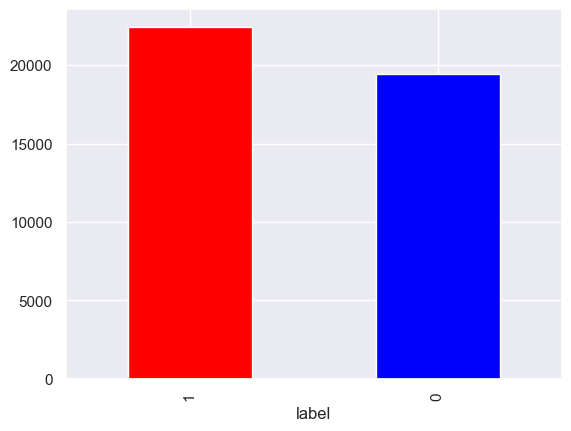

In [29]:
df_train['label'].value_counts(normalize=True)
#bar plot of the label column
df_train['label'].value_counts().plot.bar()
print(df_train['label'].value_counts(normalize=True))
df_train['label'].value_counts().plot.bar(color=['red','blue'])

As we can see, the dataset is slightly skewed with 53.62% of the instances labeled as 1 and 46.38% labeled as 0. This is a relatively balanced dataset, which is advantageous for training a predictive model. If the data were more heavily skewed towards one class, it would have been more challenging for the model to accurately predict the less represented class, potentially leading to a bias in the model’s predictions.

This explanation highlights the importance of the class distribution in machine learning and the potential implications if the dataset were more imbalanced.

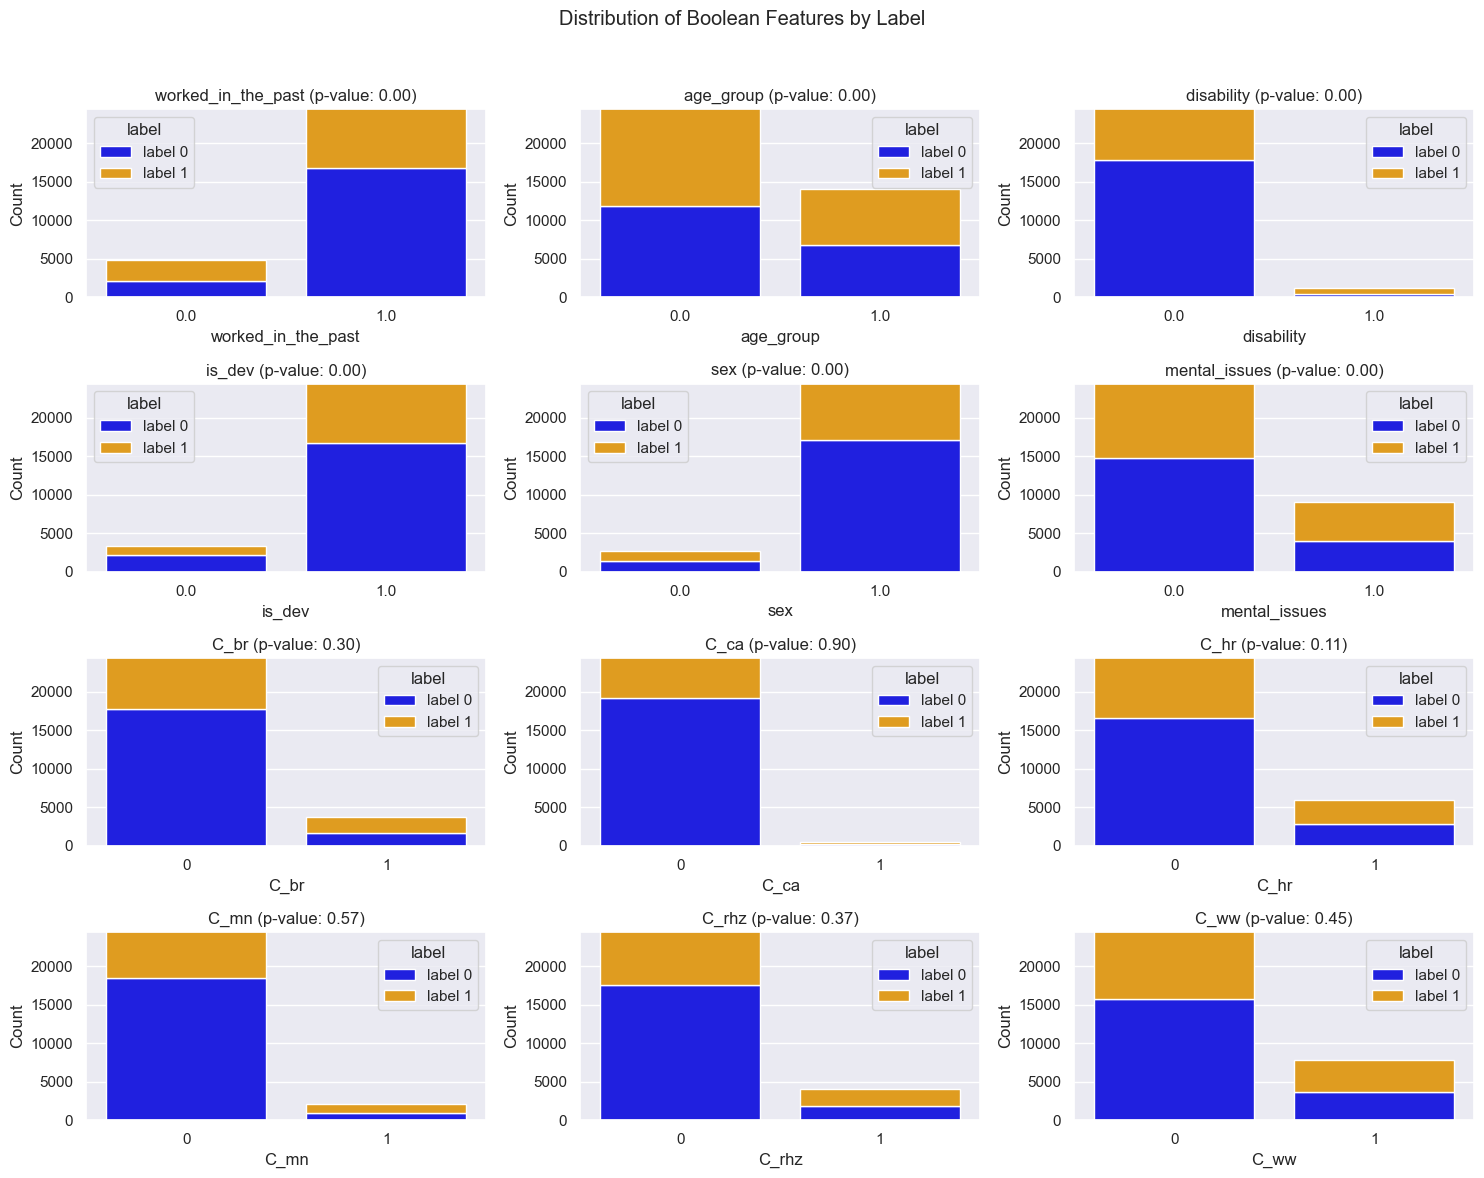

In [30]:
from scipy.stats import chi2_contingency
# Calculate Chi-squared test for each feature and store results
chi2_results = {}
for col in binary_cols:
    # Create a contingency table
    contingency_table = pd.crosstab(df_train[col], df_train['label'])

    # Check if the table has sufficient data for the test
    if contingency_table.shape == (2, 2) and contingency_table.sum().sum() > 0:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_results[col] = {'chi2': chi2, 'p-value': p, 'dof': dof, 'expected': expected}

# Plot the results in subplots with a unified scale
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
fig.suptitle('Distribution of Boolean Features by Label')

# Set a common y-axis limit
max_count = max([pd.crosstab(df_train[col], df_train['label']).values.max() for col in chi2_results.keys()])
y_limit = max_count + (max_count * 0.1)

for i, (col, result) in enumerate(chi2_results.items()):
    ax = axes[i//3, i%3]
    contingency_table = pd.crosstab(df_train[col], df_train['label'])
    sns.barplot(x=contingency_table.index, y=contingency_table[0], color='blue', label='label 0', ax=ax)
    sns.barplot(x=contingency_table.index, y=contingency_table[1], color='orange', bottom=contingency_table[0], label='label 1', ax=ax)
    ax.set_title(f'{col} (p-value: {result["p-value"]:.2f})')
    ax.set_ylim(0, y_limit)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(title='label')

fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
plt.show()



### **Ranking of Boolien Features by Statistical Significance**
A p-value less than 0.05 indicates statistical significance, meaning there is likely a relationship between the feature and the label. On the other hand, the categories of the C variable did not show a significant impact on the model, likely because there are six different categories within C, and each individual can only belong to one of them. As a result, most candidates receive a value of 0 in five out of the six categories, leading to more 0s than 1s in each category.

This situation creates an imbalanced distribution of 0s and 1s within each category of C, which leads to higher p-values and a lack of statistical significance. In contrast, binary features like worked_in_the_past or age_group, which only have two possible values (0 or 1), show a clearer distribution of labels. Consequently, the Chi-Square test is more sensitive to changes in these features, resulting in lower, more significant p-values. Therefore, these features are likely to have a greater impact on the label.Based on p-values, the features ranked by importance are: is_dev, worked_in_the_past, disability, sex, age_group, mental_issues

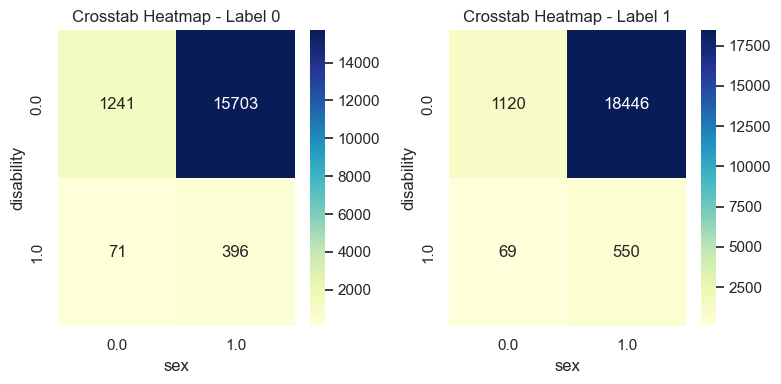

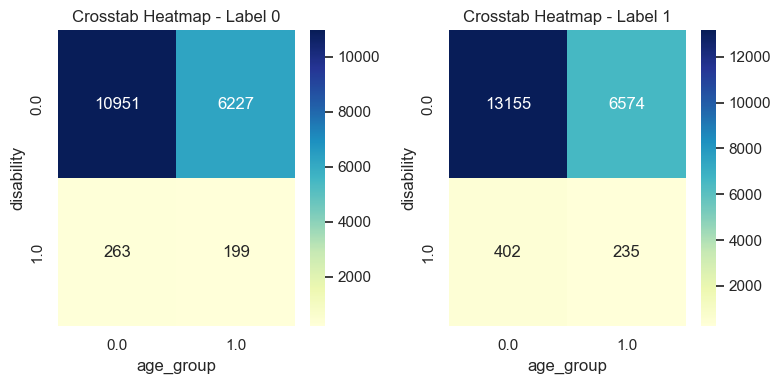

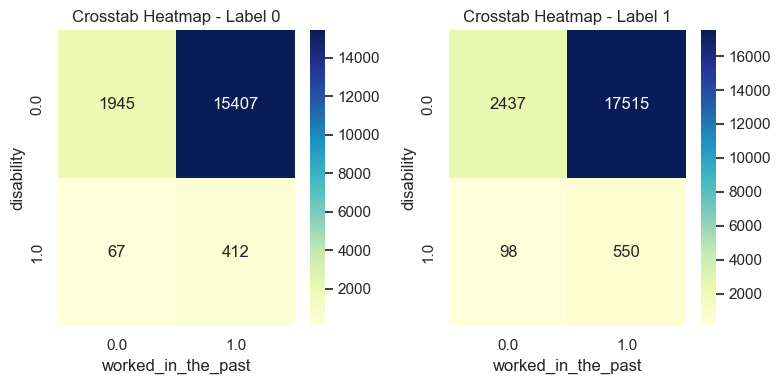

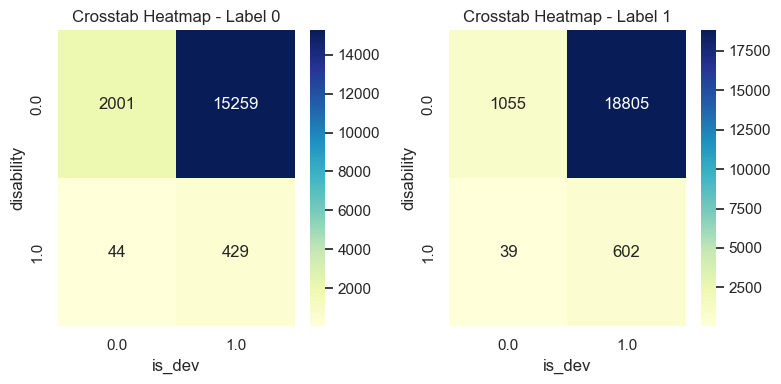

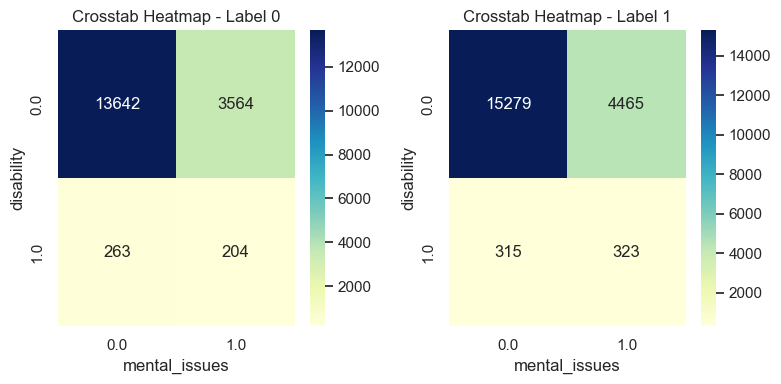

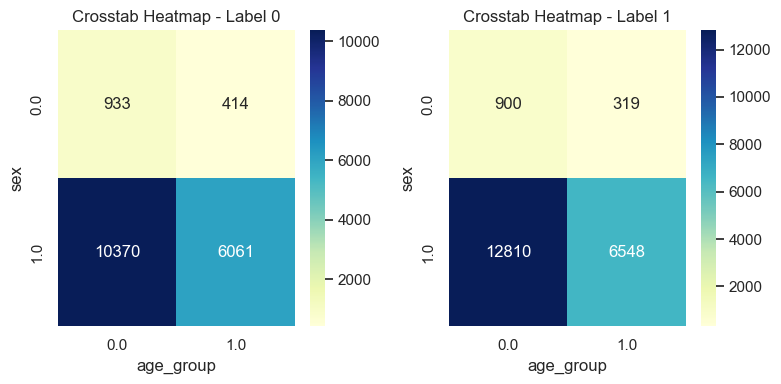

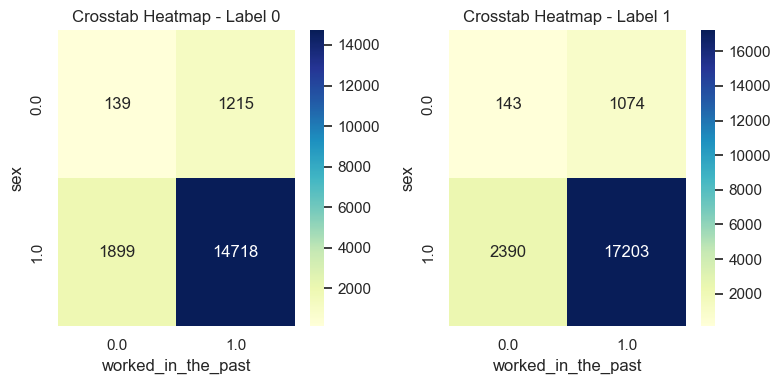

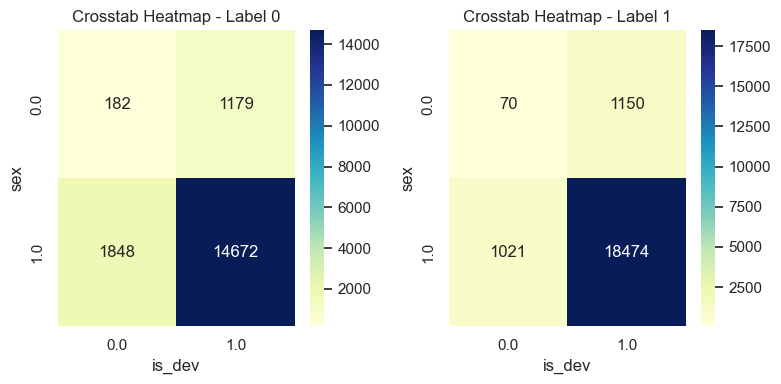

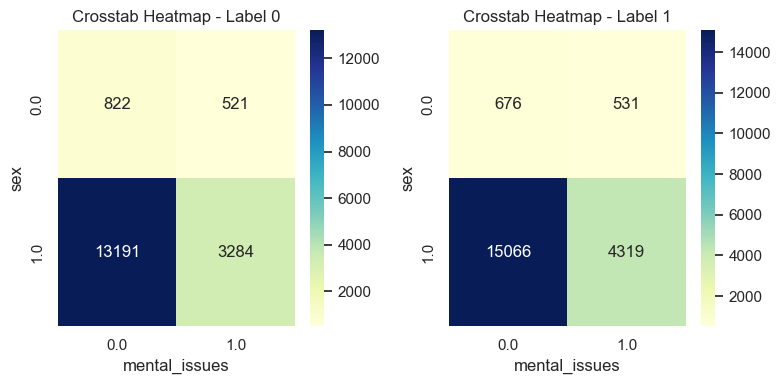

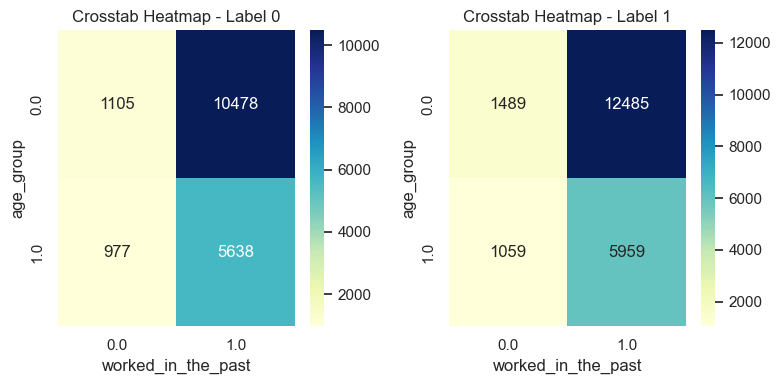

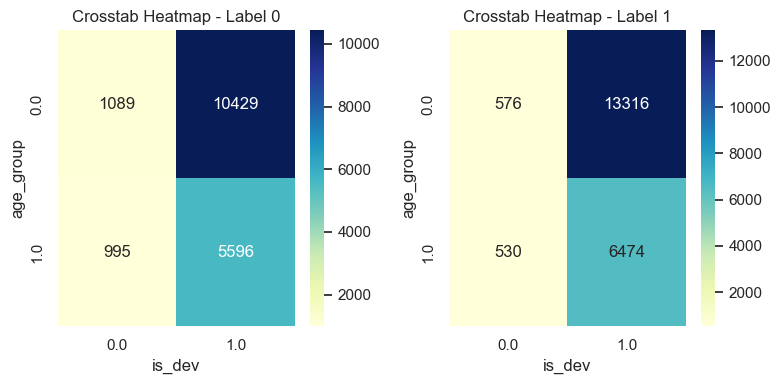

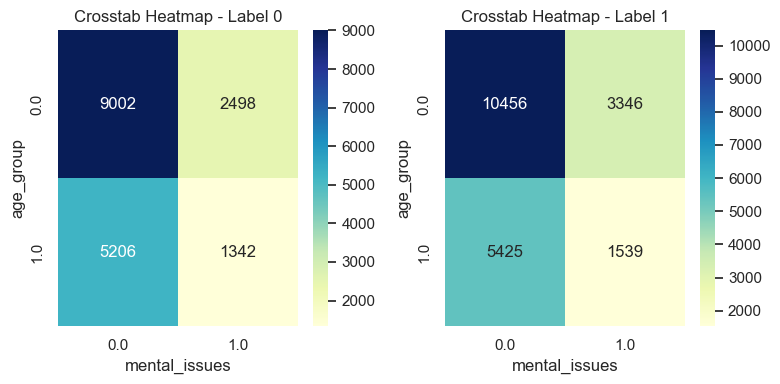

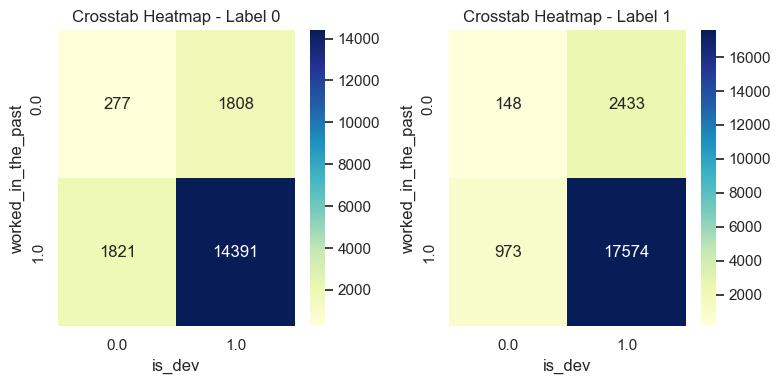

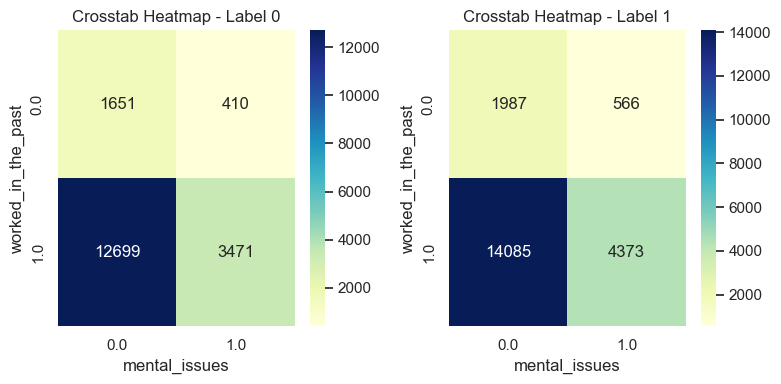

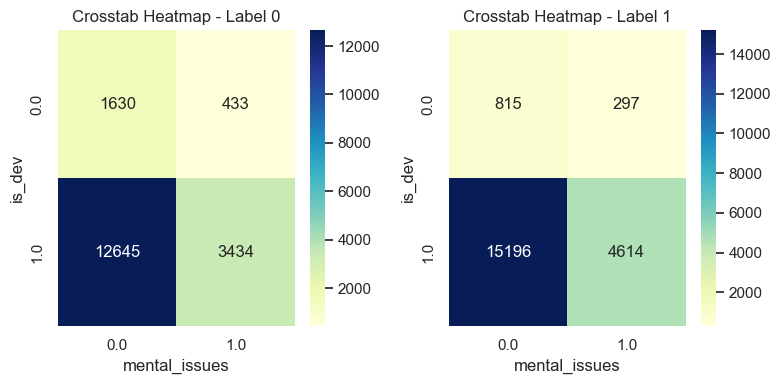

In [31]:
# Define a function to plot crosstab heatmaps for each interaction
def plot_crosstab_heatmap(feature1, feature2):
    plt.figure(figsize=(8, 4))

    # Crosstab for label == 0
    plt.subplot(1, 2, 1)
    not_hired = pd.crosstab(df_train[df_train['label'] == 0][feature1], df_train[df_train['label'] == 0][feature2])
    sns.heatmap(not_hired, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Crosstab Heatmap - Label 0')
    plt.xlabel(feature2)
    plt.ylabel(feature1)

    # Crosstab for label == 1
    plt.subplot(1, 2, 2)
    hired = pd.crosstab(df_train[df_train['label'] == 1][feature1], df_train[df_train['label'] == 1][feature2])
    sns.heatmap(hired, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f'Crosstab Heatmap - Label 1')
    plt.xlabel(feature2)
    plt.ylabel(feature1)

    plt.tight_layout()
    plt.show()

# Loop through pairs of boolean columns and plot their crosstab heatmaps
for i in range(len(boolean_cols)):
    for j in range(i + 1, len(boolean_cols)):
        plot_crosstab_heatmap(boolean_cols[i], boolean_cols[j])

### **Analysis of Additional Crosstab Heatmaps**

Age Group and Developer Status:

Label 0: Majority are younger non-developers; older developers are fewer.
Label 1: Majority are younger developers; older non-developers are fewer.
Conclusion: Younger developers are more likely to be accepted for jobs.

Age Group and Mental Issues:

Label 0 & 1: Majority are younger individuals without mental issues; older individuals with mental issues are fewer.
Conclusion: Younger individuals without mental issues have a higher likelihood of job acceptance.

Worked in the Past and Developer Status:

Label 0 & 1: Majority are developers who have worked in the past; few non-developers who have not worked in the past.
Conclusion: Prior work experience and being a developer are strong predictors of job acceptance.

Worked in the Past and Mental Issues:

Label 0 & 1: Majority are individuals without mental issues who have worked in the past; few with mental issues who have not worked in the past.
Conclusion: Prior work experience and lack of mental issues strongly predict job acceptance.

Developer Status and Mental Issues:

Label 0 & 1: Majority are developers without mental issues; few non-developers with mental issues.
Conclusion: Being a developer without mental issues significantly increases job acceptance likelihood.

Overall Insights:
Younger developers and younger individuals without mental issues are more likely to be accepted.
Prior work experience and lack of mental issues are strong predictors of job acceptance.
Developer status combined with lack of mental issues significantly increases job acceptance probability.

Number of NaN in worked_in_the_past: 1136
Number of NaN in age_group: 1568
Number of NaN in disability: 2348
Number of NaN in is_dev: 1321
Number of NaN in sex: 1987
Number of NaN in mental_issues: 1518
Number of NaN in C_br: 0
Number of NaN in C_ca: 0
Number of NaN in C_hr: 0
Number of NaN in C_mn: 0
Number of NaN in C_rhz: 0
Number of NaN in C_ww: 0


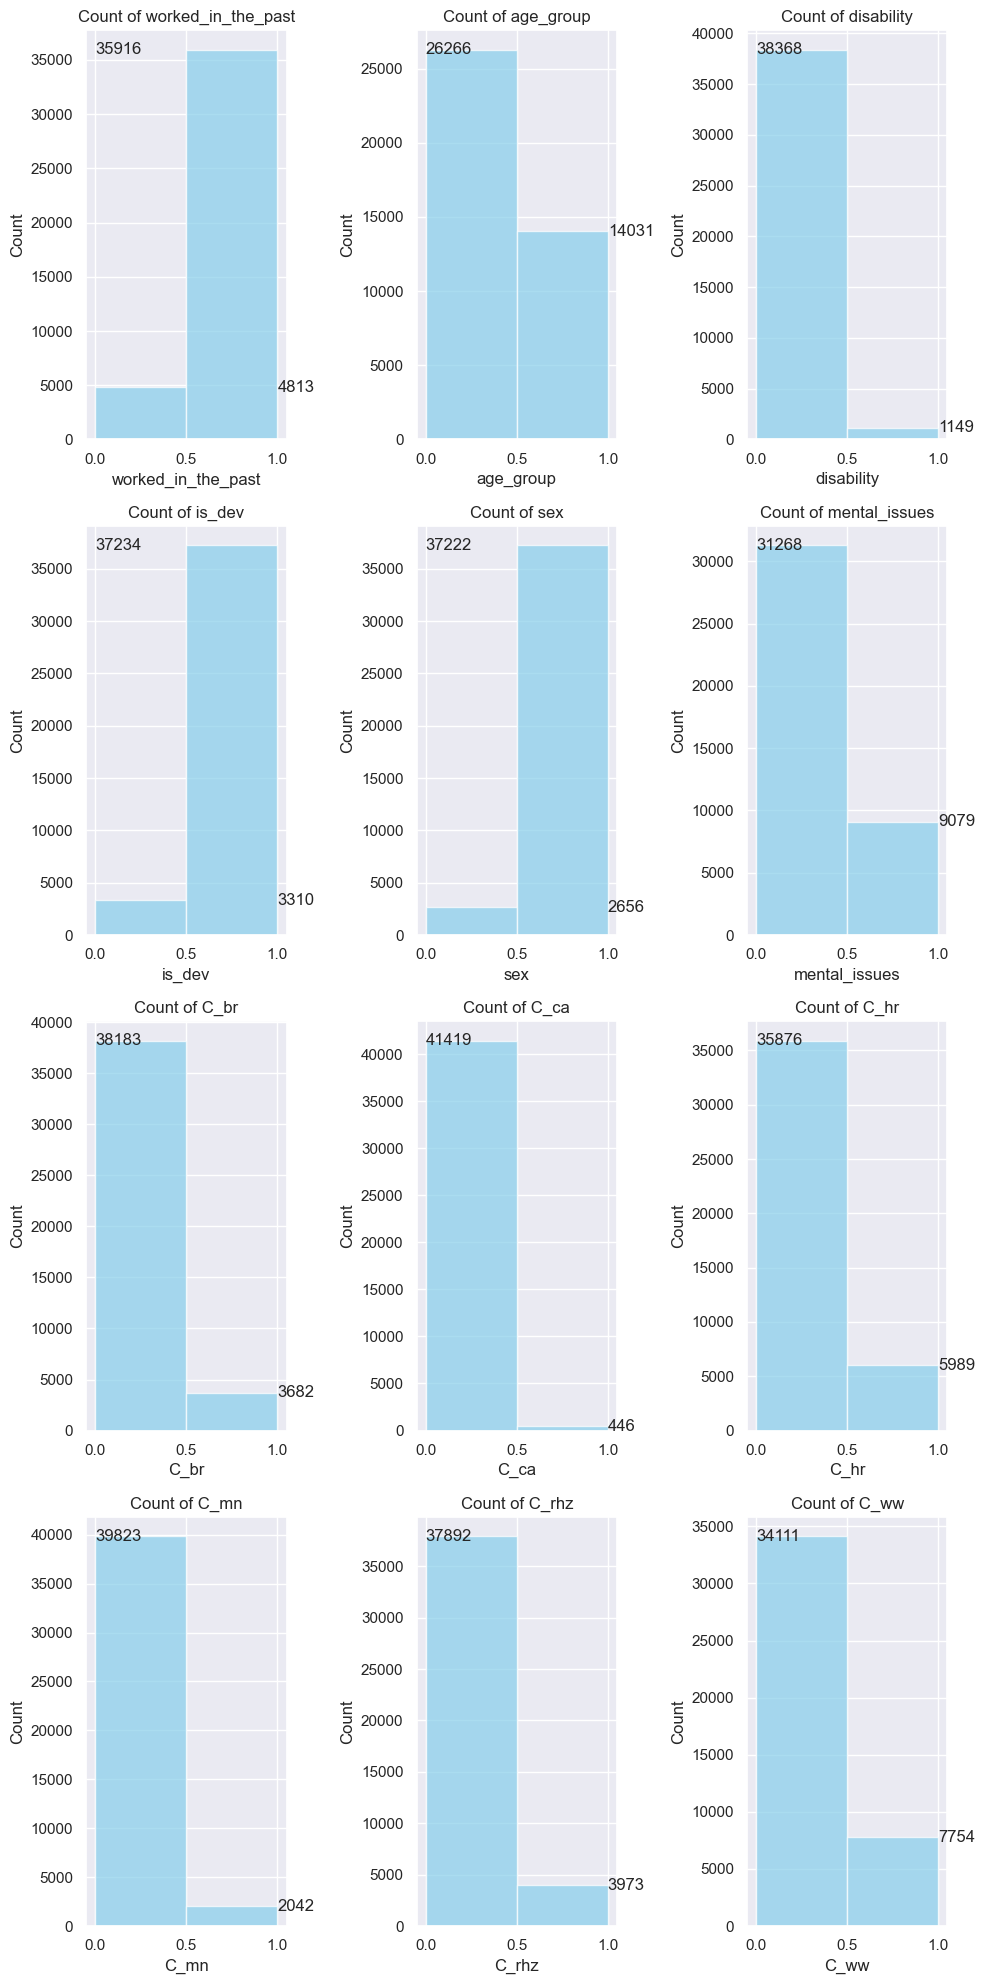

Number of NaN in education: 1902
Number of NaN in years_of_experience: 1590
Number of NaN in A: 1311
Number of NaN in B: 2190
Number of NaN in D: 1665
Number of NaN in prev_salary: 1699
Number of NaN in stack_experience: 9699
Number of NaN in continent_encoded: 2870


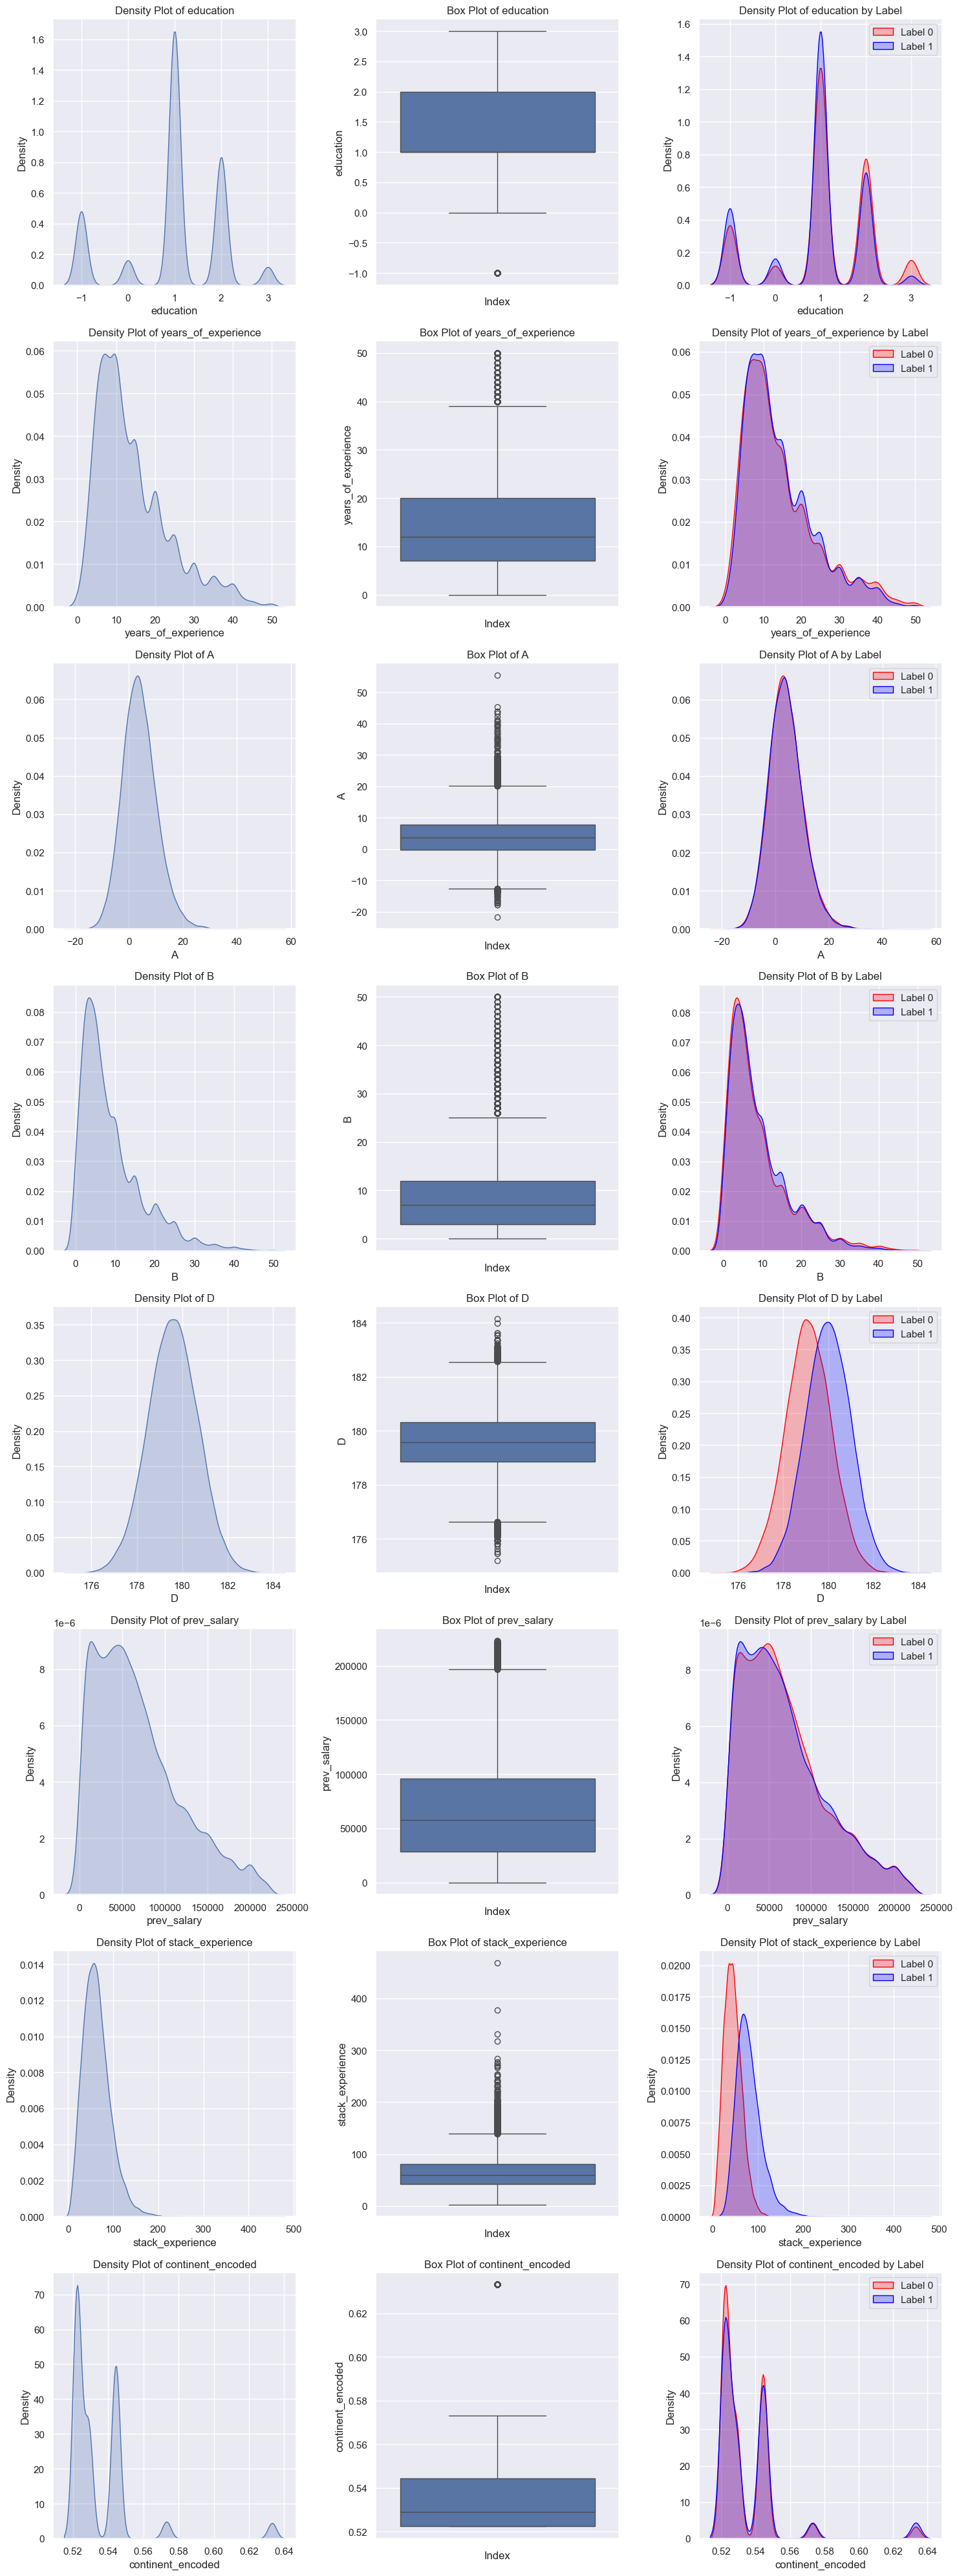

In [32]:
# 1. Histogram for each binary column with annotations
num_binary_cols = len(binary_cols)
rows = (num_binary_cols + 2) // 3  # Adjust the number of rows
fig, axs = plt.subplots(rows, 3, figsize=(10, rows * 5))

for i, cat in enumerate(binary_cols):
    ax = axs[i // 3, i % 3]
    value_counts = df_train[cat].value_counts()
    ax.hist(df_train[cat].dropna(), bins=2, color='skyblue', alpha=0.7)
    ax.set_title(f'Count of {cat}')
    ax.set_xlabel(cat)
    ax.set_ylabel('Count')
    print(f"Number of NaN in {cat}: {df_train[cat].isnull().sum()}")
    # Annotate each bar with the count value
    for index, value in enumerate(value_counts):
        ax.text(index, value, str(value), va='center')

plt.tight_layout()
plt.show()
# Assume numerical_cols is defined and df_train is your DataFrame
num_numerical_cols = len(numerical_cols)
fig, axs = plt.subplots(num_numerical_cols, 3, figsize=(15, num_numerical_cols * 5))  # Adjust the number of columns to 3

for i, num in enumerate(numerical_cols):
    # Print the number of NaN values in the column
    print(f"Number of NaN in {num}: {df_train[num].isnull().sum()}")

    # Density Plot
    sns.kdeplot(df_train[num].dropna(), shade=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Density Plot of {num}')
    axs[i, 0].set_xlabel(num)
    axs[i, 0].set_ylabel('Density')

    # Box Plot
    sns.boxplot(y=df_train[num], ax=axs[i, 1])
    axs[i, 1].set_title(f'Box Plot of {num}')
    axs[i, 1].set_xlabel('Index')
    axs[i, 1].set_ylabel(num)

    # Density Plot by Label
    label_colors = {0: 'red', 1: 'blue'}
    for label in df_train['label'].unique():
        sns.kdeplot(df_train[df_train['label'] == label][num].dropna(), shade=True, color=label_colors[label], label=f'Label {label}', ax=axs[i, 2])
    axs[i, 2].set_title(f'Density Plot of {num} by Label')
    axs[i, 2].set_xlabel(num)
    axs[i, 2].set_ylabel('Density')
    axs[i, 2].legend()

plt.tight_layout()
plt.show()



## **about the results**:
**Missing Values**: from the result we can see thst ther are NaN in every feature, and we will dill with it latter in the code.

**summery and our assumptions from the results:** The variables stack_experience and D show relatively low overlap between label distributions, with a clear tendency for Label 1 to be associated with higher values, indicating their importance in predicting the label. In contrast, variables such as prev_salary, years_of_experience, education, and continent_encoded exhibit higher overlap between labels, suggesting they may be less useful for differentiation. Both stack_experience and prev_salary also demonstrate wider dispersion and numerous outliers, which could indicate a potential impact of extreme values on model outcomes. While D and education have distributions closer to normal, stack_experience and prev_salary display highly skewed distributions, complicating interpretation. Overall, stack_experience and D appear to be more significant, while the other variables may contribute when combined in the overall analysis.

**count of sex:** Due to the relatively small number of individuals in the 'Other' category compared to males and females, we decided to merge the 'Other' category with the 'Female' category, as the number of females is the smallest among the two main groups. This adjustment is expected to have minimal impact on the analysis. Additionally, we aimed to convert this variable into a binary variable for computational convenience.

**Density Plot of D by Label**:
The variable D follows a normal distribution, with a mean around 180, as indicated by the symmetrical bell curve representing its overall distribution. The Box Plot analysis shows that the central values of D range between 178 and 182, with a median close to 180, and there are some outliers beyond the interquartile range. When examining the distribution by labels, there is significant overlap between Label 0 (red) and Label 1 (blue), although there is a slight tendency for higher values of D to be associated with Label 1. However, the overlap between the distributions suggests that the variable D alone is not sufficient for accurate differentiation between the labels.

**Density Plot of B by Label**:
The distributions of B for both labels are almost identical.
Both distributions peak around the same value and follow similar patterns throughout the range.
Conclusion: The feature B does not show a significant difference between the two labels, indicating that it might not be a strong distinguishing factor.

**Density Plot of A by Label**:
The distributions of A for both labels are nearly identical, both are normally disterbuted..
Both distributions peak around the same value and follow similar patterns throughout the range.
The feature A does not show a significant difference between the two labels, indicating that it might not be a strong distinguishing factor.

**Density Plot of education by Label**:
Education Level -1 (Other): Individuals with 'other' education levels are slightly more likely to get the job.
Education Level 0 (High school): Having a high school education does not significantly affect the chances of getting the job, as the densities are similar for both labels.
Education Level 1 (BA/BSc): Individuals with a BA/BSc degree are more likely to get the job compared to those who did not, indicating a positive correlation between having a BA/BSc and getting the job.
Education Level 2 (MA/MSc): Individuals with an MA/MSc degree have a slightly higher chance of not getting the job, though the distribution is relatively even.
Education Level 3 (Phd): Individuals with a Phd are slightly more likely to not get the job compared to those who did., which can be useful for distinguishing between Label 0 and Label 1.
Education Levels -1 and 1 show the most characteristics of a normal distribution with their bell-shaped curves.

Education Levels 0 and 3 do not show a clear normal distribution due to their low densities and lack of a bell-shaped curve.
Education Level 2 shows some characteristics of a normal distribution, but it is not perfect.

**Density Plot of stack_experience by Label**:
The variable stack_experience shows a skewed distribution, with most values concentrated between 0 and 100, as indicated by the Density Plot. There is a long tail towards higher values, indicating a few instances with significantly higher stack experience. The Box Plot highlights this further, showing a concentration of values in the lower range with numerous outliers in the higher range. When examining the distribution by labels, there is a noticeable tendency for lower stack experience values to be associated with Label 0, while higher values are more commonly linked to Label 1. Despite some overlap between the distributions of the two labels, candidates with higher stack experience are more likely to be categorized under Label 1. This suggests that stack_experience could be a useful predictor for label classification, although the overlap should be considered togeter with feature D.

**Density Plot of prev salary by label:** he density plot suggests that there is no significant difference in the distribution of years of experience between the two labels (Label 0 and Label 1).
The similarity in the distribution patterns indicates that years of experience may not be a strong distinguishing factor between the two labels by itself.

**Density Plot of years of exprience by label:** The density plot suggests that there is no significant difference in the distribution of years of experience between the two labels (Label 0 and Label 1).
The similarity in the distribution patterns indicates that years of experience may not be a strong distinguishing factor between the two labels by itself.







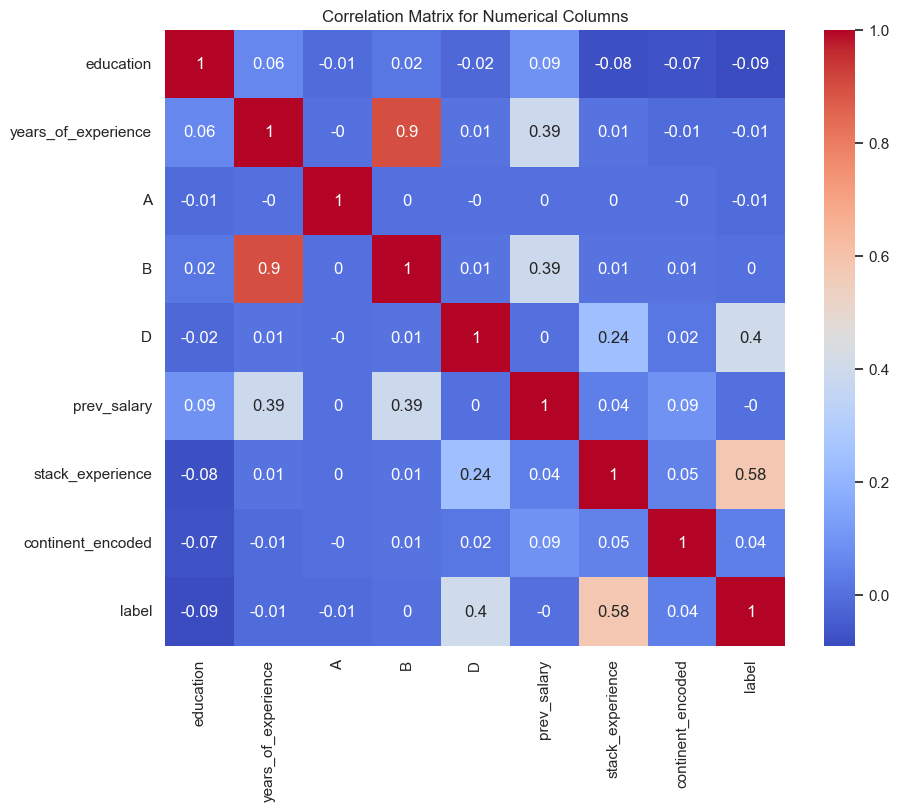

In [33]:
# plotting a correlation heatmap for numric correlations
cols_to_plot = numerical_cols+['label']
corr_numerical = df_train[cols_to_plot].corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_numerical, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix for Numerical Columns")
plt.show()

# **conclusions:**

The correlation matrix shows a strong relationship of 0.9 between years_of_experience and B, suggesting that more years of experience are associated with a higher rating in B. Due to this linear relationship, we decided to merge these features (see Appendices 5 and 6). Additionally, there is a strong correlation of 0.58 between stack_experience and the label, and a correlation of 0.4 between D and the label, supporting our earlier hypothesis about the significance of these variables in predicting the label.

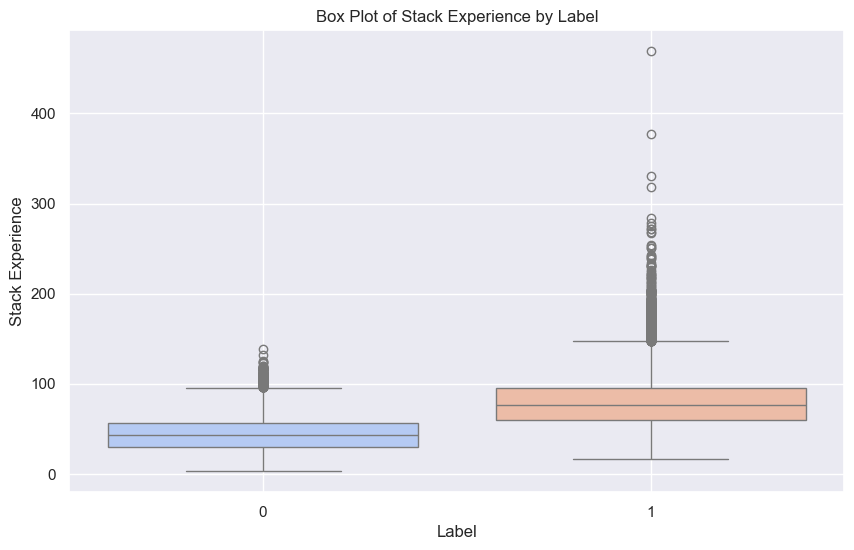

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='label', y='stack_experience', palette='coolwarm')
plt.title('Box Plot of Stack Experience by Label')
plt.xlabel('Label')
plt.ylabel('Stack Experience')
plt.grid(True)
plt.show()

conclusion: The higher median and broader distribution of stack experience for Label 1 suggests that stack experience is more influential or prevalent among this group, potentially indicating a higher professional level or more complex job roles. In contrast, Label 0 shows a lower median and a narrower IQR, indicating that most of the data for Label 0 is concentrated around lower stack experience values. This suggests that individuals with Label 1 generally have more stack experience and greater variability in their experience levels, highlighting the significance of stack experience in determining label outcomes.
These outliers could indicate unique cases, such as highly experienced professionals or specialists in certain technologies. Outliers can significantly influence model results and predictions, so it's important to analyze them carefully to determine whether they should be included, transformed, or possibly excluded from the dataset to ensure accurate and balanced analysis, so we will "take care of them" later.

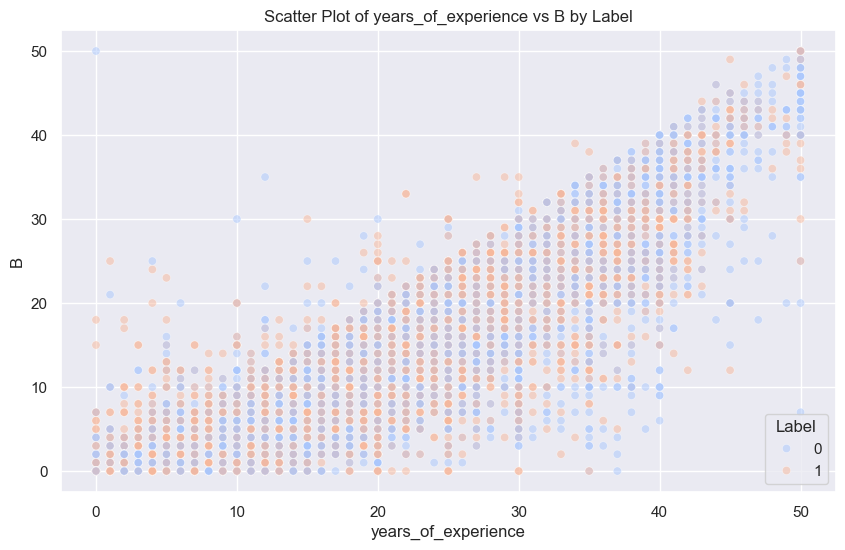

In [35]:
# Scatter plot for the interaction between 'B' and 'years_of_experience'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='years_of_experience', y='B', hue='label', palette='coolwarm', alpha=0.5)
plt.title('Scatter Plot of years_of_experience vs B by Label')
plt.xlabel('years_of_experience')
plt.ylabel('B')
plt.legend(title='Label')
plt.grid(True)
plt.show()

The strong correlation between 'B' and 'years_of_experience' suggests that interaction terms or transformations of these features could be useful in modeling. For example, a new feature representing the product or ratio of these two could capture the interaction more effectively.

# **Handle missing values:**

Are there any missing values? How did you choose to handle them and why in this way?

In [36]:
#counting the number of rows with any null values
df_train.isnull().any(axis=1).sum()

25133

There are 25,133 rows with missing values. if we going remove all the missing value we gonna lose half of our data so we need to use method to fill them wisely.

we chose to use in SimpleImputer function:

1. binary_cols - For binary columns, the mode (most frequent value) is typically used to fill in missing values. When there is such a large disparity between the frequency of values in binary columns, using the most frequent value to fill in missing data helps preserve the original distribution and prevents introducing bias into the model. This approach ensures that the missing values are filled with a value that accurately represents the majority of the data in that column, maintaining consistency in the analysis results.

2. numerical_cols - The median is often preferred for numerical data because it is less sensitive to outliers than the mean. In our case, since the distributions in our dataset are not normal, we chose the median for handling missing values. This approach helps avoid bias from skewness or outliers, providing a more accurate measure of central tendency in non-symmetrical data, ensuring the imputation process is robust and reliable.

In [37]:
from sklearn.impute import SimpleImputer
def impute_missing_values(df, numerical_cols, binary_cols):
    """
    Imputes missing values in the dataframe for numerical and binary columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    numerical_cols (list): List of numerical column names.
    binary_cols (list): List of binary (categorical) column names.

    Returns:
    pd.DataFrame: The dataframe with imputed values.
    """

    # Define imputers for numerical and binary features
    num_imputer = SimpleImputer(strategy='median')
    bin_imputer = SimpleImputer(strategy='most_frequent')

    # Apply imputation to numerical columns
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

    # Apply imputation to binary columns
    df[binary_cols] = bin_imputer.fit_transform(df[binary_cols])

    return df

In [38]:
df_train = impute_missing_values(df_train,numerical_cols,binary_cols)
print("Missing values are :", df_train.isnull().sum())

Missing values are : worked_in_the_past     0
age_group              0
disability             0
is_dev                 0
education              0
sex                    0
mental_issues          0
years_of_experience    0
A                      0
B                      0
D                      0
prev_salary            0
stack_experience       0
C_br                   0
C_ca                   0
C_hr                   0
C_mn                   0
C_rhz                  0
C_ww                   0
continent_encoded      0
label                  0
dtype: int64


# **Handle the outliers:**

"Are there any outliers in the data? If so, should you remove them or at least address them?"

Initially, we visualized the data for each column using graphs to observe the measurement results (visualization). Upon inspection, we identified the presence of outliers. During the preprocessing phase, we conducted two experiments: the first involved removing the outliers, and the second involved bringing the outliers closer to the core distribution. Below are explanations of these two approaches.

**First Attempt - Removing Outliers**: To prevent the influence of outliers on the models, in the first attempt, we decided to remove these outliers (half a percent of the most extreme samples from each column - those with the highest and lowest values). It is important to note that when we identified an outlier in a particular feature, we removed the entire row from the dataset to avoid affecting the conclusions and models.

This was an attempt to address the outliers. However, this approach proved to be unsuccessful because it resulted in filtering out approximately 15% of the data. Therefore, we decided to change our approach to bringing the extreme values closer to the core of the data distribution.

**Second Attempt - Winsorization**:
In the second attempt, we used Winsorization by applying the QUANTILE function, which receives a specified percentile and returns the value defining the boundary of that percentile. We then adjusted all outliers to this number found by the function. In other words, all extreme samples were adjusted to the nearest value according to the chosen percentile.

It is important to emphasize that the first attempt was purely experimental and does not have a place in the final workflow.

Decision-Making Process: The decision on how to perform the adjustment was made based on the data distribution for each feature. For example, if we observed that the outliers were only present at one extreme of the data (e.g., only in the upper part of the data - at the 99th percentile), the adjustment was made only for the upper part, with all samples exceeding the set percentile being adjusted to the percentile value.

You can observe the change in the histograms below. For example, the rightmost edge of the graph represents the highest values of the stack_experience feature, which refers to cases with significant experience in technologies. Before applying Winsorization, there were extremely high outliers in this area. After Winsorization, these high values were capped and shifted towards the center, thereby reducing their impact on the overall data distribution.

This analysis was conducted for each feature, and the action plan implemented is shown in the code below.



we plot again just the boxplots of the numerical_cols to visual and analyze the outliers on the numeric.

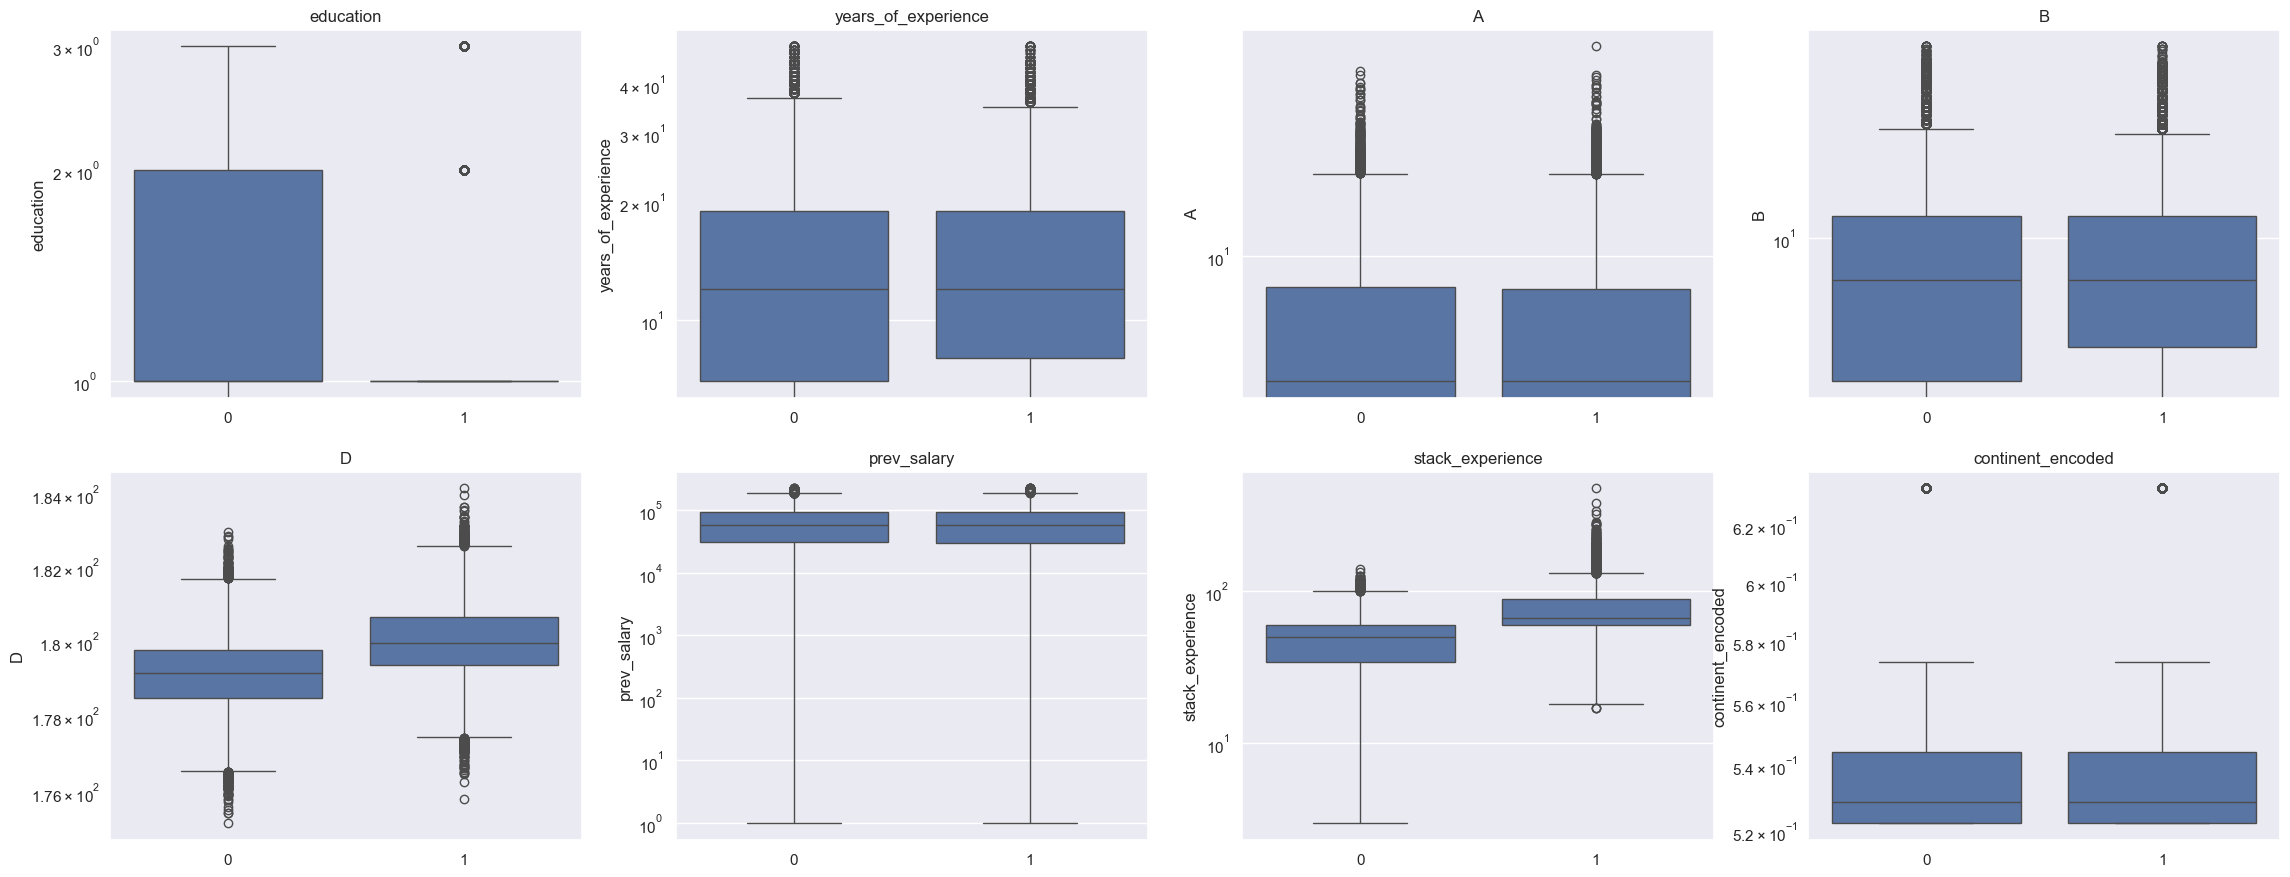

In [39]:
plt.figure(figsize=(28,22))
for i,v in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    # log scale the box plot for better visualization
    sns.boxplot(x='label', y=v, data=df_train, showfliers=True)
    #dont show the x label
    plt.xlabel('')
    # log scale the y axis for better visualization
    plt.yscale('log')
    plt.title(v)
plt.show()



# **Winsorization:**

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def winsorize_outliers_and_plot(df, num=1):
    """
    Function to winsorize specified features in a dataframe and optionally plot the results.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    num (int): If 1, plots the histogram of the features before and after winsorization.
    """

    features = ["stack_experience", "A", "B", "D", "prev_salary", "years_of_experience"]

    for feature in features:
        if num == 1:
            # Plot before winsorization
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.hist(df[feature].dropna(), bins=20, color='blue', alpha=0.7)
            plt.title(f'{feature} before winsorization')
            plt.yscale("log")
            plt.xlabel(feature)
            plt.ylabel('Count')

        # Determine quantile limits for winsorization
        if feature in [ "A", "B","prev_salary"]:
            top_limit = df[feature].quantile(0.99)
            df[feature] = np.where(df[feature] > top_limit, top_limit, df[feature])
        elif feature in [ "stack_experience", "years_of_experience"]:
            top_limit = df[feature].quantile(0.95)
            df[feature] = np.where(df[feature] > top_limit, top_limit, df[feature])

        if num == 1:
            # Plot after winsorization
            plt.subplot(1, 2, 2)
            plt.hist(df[feature].dropna(), bins=20, color='green', alpha=0.7)
            plt.title(f'{feature} after winsorization')
            plt.yscale("log")
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.tight_layout()
            plt.show()

    return df




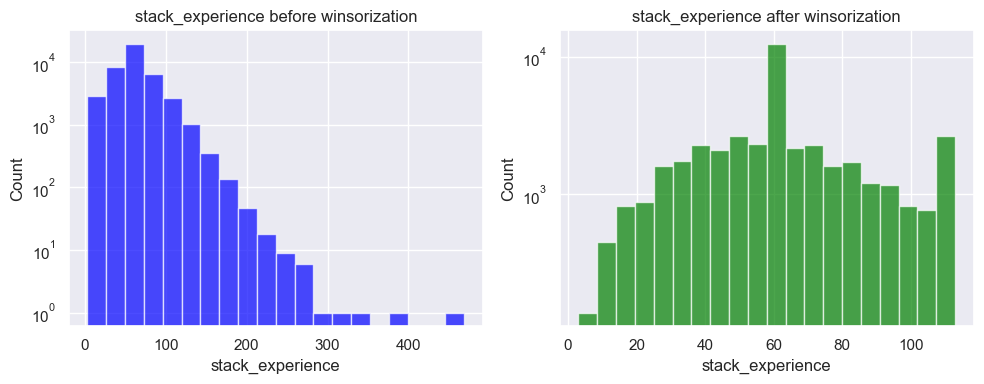

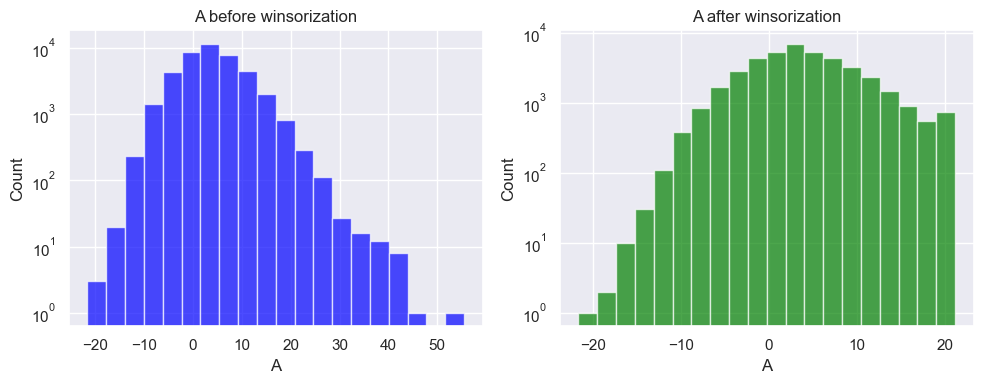

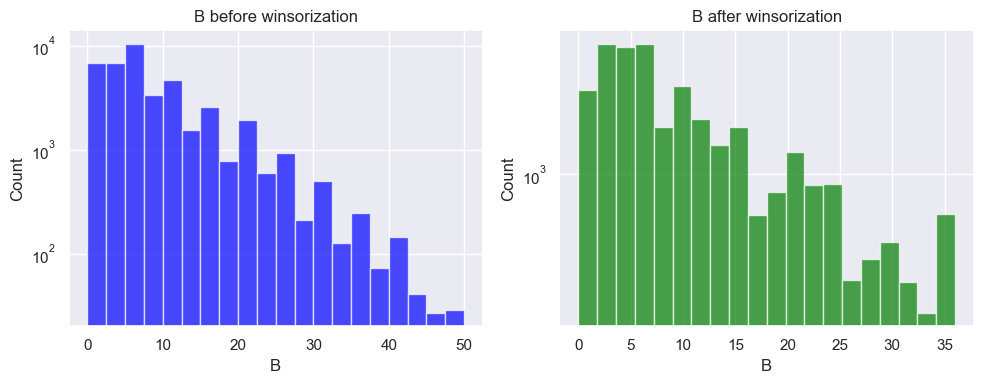

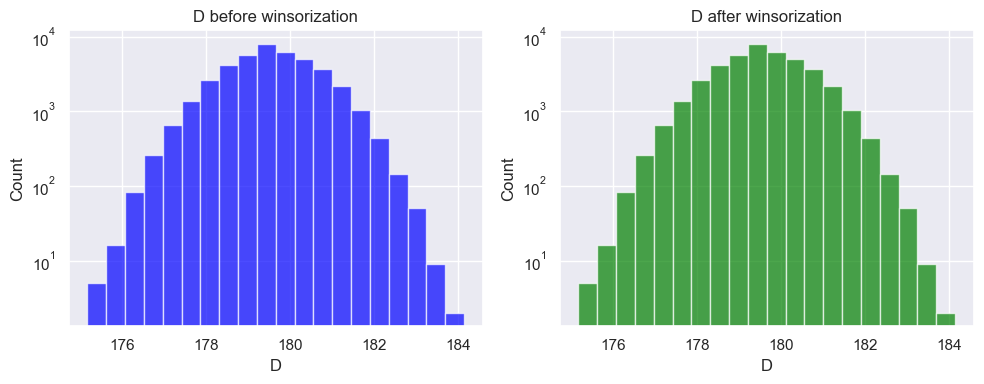

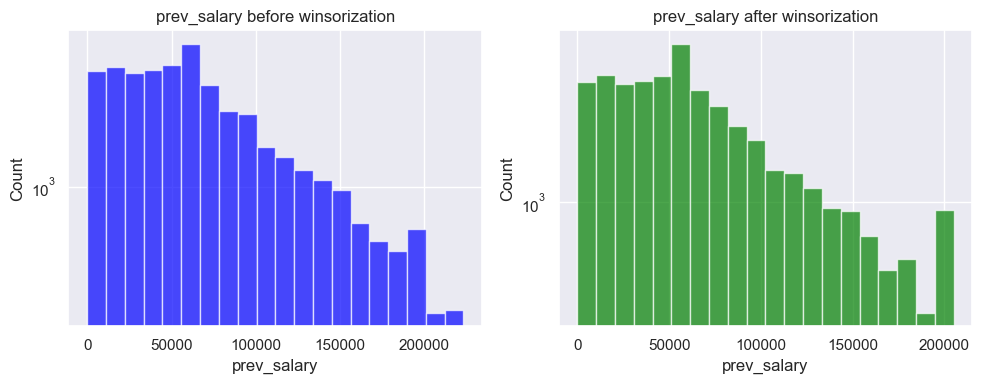

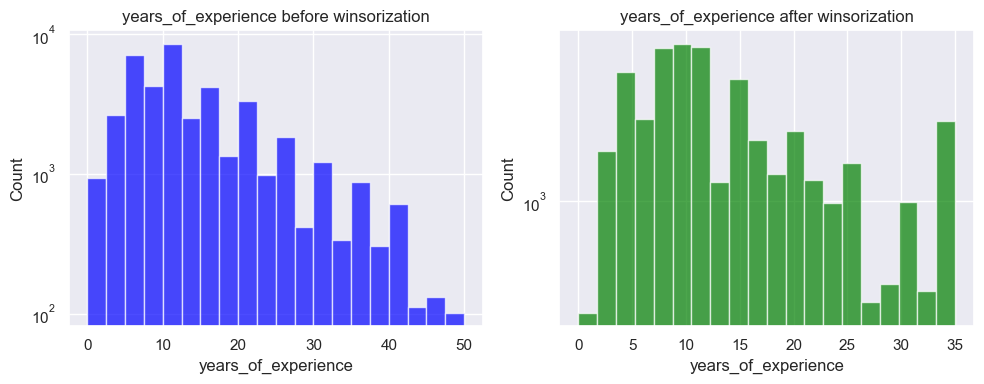

In [41]:
# Apply the function to df_train
df_train = winsorize_outliers_and_plot(df_train, num=1)

In [42]:
#this method give losing of 15% of the data - just to show not to run!
#def detect_outliers_iqr(data, threshold=1.5):
    #Q1 = data.quantile(0.25)
   # Q3 = data.quantile(0.75)
  #  IQR = Q3 - Q1
 #   lower_bound = Q1 - threshold * IQR
#    upper_bound = Q3 + threshold * IQR
#    outliers = (data < lower_bound) | (data > upper_bound)
#    print(f"Outliers detected by IQR method in {data.name}: {outliers.sum()}")
#    return outliers

#def detect_outliers_zscore(data, threshold=3):
    #mean = np.mean(data)
    #std = np.std(data)
   # z_scores = (data - mean) / std
  #  outliers = np.abs(z_scores) > threshold
 #   print(f"Outliers detected by Z-score method in {data.name}: {outliers.sum()}")
#    return outliers

#def remove_outliers(df):
    #initial_shape = df.shape
    #print(f"Initial shape of data: {initial_shape}")

    # Stack Experience (IQR method)
    #outliers_stack_exp = detect_outliers_iqr(df['stack_experience'])
    #df = df[~outliers_stack_exp]

    # A, B, D (IQR method)
    #for col in ['A', 'B', 'D']:
        #outliers_anonymous = detect_outliers_iqr(df[col])
        #df = df[~outliers_anonymous]

    # Prev Salary (Z-score method)
    #outliers_prev_salary = detect_outliers_zscore(df['prev_salary'])
    #df = df[~outliers_prev_salary]

    # Years of Experience (Z-score method)
    #outliers_years_exp = detect_outliers_zscore(df['years_of_experience'])
    #df = df[~outliers_years_exp]

    #final_shape = df.shape
    #print(f"Shape after removing outliers: {final_shape}")
    #print(f"Total rows removed: {initial_shape[0] - final_shape[0]}")

    #return df

# Apply outlier detection to df_train
#df_train = remove_outliers(df_train)

# **Add new feature:**
In this section of the code, we implemented a new feature by combining two existing features—B and years_of_experience. The objective was to create a ratio between these features and evaluate its significance in the model.

First, we used the function add_new_corr_feature to calculate the ratio between B and years_of_experience, resulting in a new feature named B_years_ratio. This new feature provides a combined measure that captures the relationship between these two variables.

To address potential outliers in the new feature, we applied Winsorization. This technique involves capping extreme values at specific quantile thresholds (in this case, the 99th percentile as the upper limit and the 1st percentile as the lower limit). This step ensures that outliers do not disproportionately affect the model's performance.

After creating the new feature, we removed the original features (B and years_of_experience) from the dataset. This decision was made to prevent redundancy and reduce the dimensionality of the model, which can lead to improved model performance. (positive influence in dimensional problem even before pca/feature selection).

In [43]:
def add_new_corr_feature(df, feature1, feature2, new_feature_name, train, quantile_top=0.99, quantile_bottom=0.01):
    """
    Create a new feature based on the ratio of two existing features, handling potential division by zero,
    NaN values, and outliers.

    Parameters:
    - df: DataFrame containing the data.
    - feature1: The numerator feature for the ratio.
    - feature2: The denominator feature for the ratio.
    - new_feature_name: The name of the new feature to be created.
    - quantile_top: The upper quantile for winsorizing the new feature (default is 0.99).
    - quantile_bottom: The lower quantile for winsorizing the new feature (default is 0.01).
    """
    # Check if the columns exist in the DataFrame
    if feature1 not in df.columns or feature2 not in df.columns:
        raise KeyError(f"One or both features ({feature1}, {feature2}) not found in DataFrame.")

    # Create the new ratio feature
    df[new_feature_name] = df[feature1] / df[feature2]

    # Handle division by zero or NaN values by filling them with 0
    df[new_feature_name] = df[new_feature_name].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Winsorize the new feature to handle outliers
    top_limit = df[new_feature_name].quantile(quantile_top)
    bottom_limit = df[new_feature_name].quantile(quantile_bottom)
    df[new_feature_name] = np.clip(df[new_feature_name], bottom_limit, top_limit)

    # Drop the original features if they exist
    if feature1 in df.columns:
        df = df.drop(feature1, axis=1)
    if feature2 in df.columns:
        df = df.drop(feature2, axis=1)

    if train: # moving label column to the end
        label = df.pop('label')
        df['label'] = label

    return df





In [44]:
print(df_train.columns)

Index(['worked_in_the_past', 'age_group', 'disability', 'is_dev', 'education',
       'sex', 'mental_issues', 'years_of_experience', 'A', 'B', 'D',
       'prev_salary', 'stack_experience', 'C_br', 'C_ca', 'C_hr', 'C_mn',
       'C_rhz', 'C_ww', 'continent_encoded', 'label'],
      dtype='object')


In [45]:
df_train = add_new_corr_feature(df_train, 'B', 'years_of_experience', 'B_years_ratio',True)
# Remove the original features from numerical_cols and add the new feature
numerical_cols.remove('B')
numerical_cols.remove('years_of_experience')
numerical_cols.append('B_years_ratio')
df_train.head()

worked_in_the_past  age_group  disability  is_dev  education  sex  \
3843                  1.0        1.0         0.0     1.0        2.0  1.0   
52884                 1.0        1.0         0.0     1.0       -1.0  1.0   
13649                 1.0        0.0         1.0     1.0        1.0  1.0   
33106                 1.0        0.0         0.0     1.0        1.0  1.0   
10242                 1.0        1.0         0.0     1.0        1.0  1.0   

       mental_issues          A           D  prev_salary  stack_experience  \
3843             0.0   0.189733  181.089420     100000.0              66.0   
52884            1.0   4.232576  179.399237     165000.0              60.0   
13649            1.0 -10.623775  179.272213      63986.0              22.0   
33106            0.0  -1.629383  180.369400     110000.0              58.0   
10242            0.0   1.952668  180.348724      70771.0              59.0   

       C_br  C_ca  C_hr  C_mn  C_rhz  C_ww  continent_encoded  B_years_ratio  \
3843    0.0   0.0   0.0   0.0    0.0   0.0           0.544252       1.500000   
52884   0.0   0.0   0.0   0.0    1.0   0.0           0.544252       0.846154   
13649   0.0   0.0   0.0   0.0    0.0   0.0           0.522355       0.750000   
33106   0.0   0.0   0.0   0.0    0.0   1.0           0.544252       0.777778   
10242   0.0   0.0   1.0   0.0    0.0   0.0           0.573150       0.666667   

       label  
3843       0  
52884      1  
13649      0  
33106      1  
10242      0

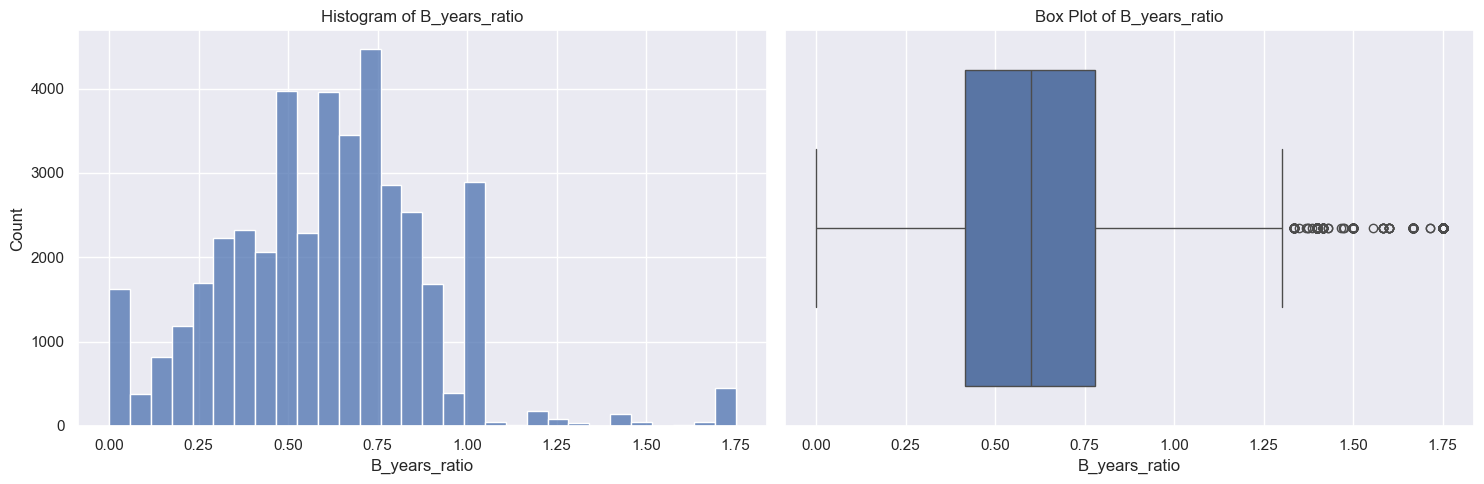

In [46]:
# Plotting outside the function
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
sns.histplot(df_train['B_years_ratio'], bins=30, kde=False, ax=axs[0])
axs[0].set_title('Histogram of B_years_ratio')
axs[0].set_xlabel('B_years_ratio')
axs[0].set_ylabel('Count')

# Box Plot
sns.boxplot(x=df_train['B_years_ratio'], ax=axs[1])
axs[1].set_title('Box Plot of B_years_ratio')
axs[1].set_xlabel('B_years_ratio')

plt.tight_layout()
plt.show()

# **Noramliztion**:
**Normalization is crucial for:**

Normalization is a key step in our data preprocessing workflow, ensuring that data scales are consistent, which prevents biases and avoids skewed results from features with different ranges. It enhances algorithm performance, particularly for models that rely on distances or gradients, by allowing them to operate more efficiently. Additionally, normalization aligns our data with the assumptions of many machine learning models, helping to achieve more accurate and effective modeling outcomes.

**Application Using Min-Max Scaler:**

In our dataset, we applied the Min-Max Scaler, a popular normalization technique that resizes the features to a fixed range, typically between 0 and 1. This technique is particularly effective in scenarios where outliers are present, as it compresses the data into a consistent scale, reducing the impact of extreme values.

Normalization in our case helps address the different feature scales, ensuring that the model is not overly influenced by features with large magnitudes. It also helps manage outliers by bringing extreme values closer to the center, making the model more robust and less sensitive to these outliers. Furthermore, normalization facilitates a more accurate comparison of different features, aiding in understanding each feature’s importance and contribution to the model. Although our chosen model is not KNN, we decided to normalize the data to allow flexibility in testing various models.

In [47]:
df_no_norm = df_train.copy()
def min_max_normalization(df,numerical_cols,train):

    '''
    input: data - dataframe, continuos_cols - list of continuos columns
    output: data - dataframe with continuos columns normalized, to be between 0 and 1
    '''

    new_df=df.copy()
    new_df[numerical_cols]=(new_df[numerical_cols]-train[numerical_cols].min())/(train[numerical_cols].max()-train[numerical_cols].min())
    return new_df

df_train=min_max_normalization(df_train,numerical_cols,df_train)

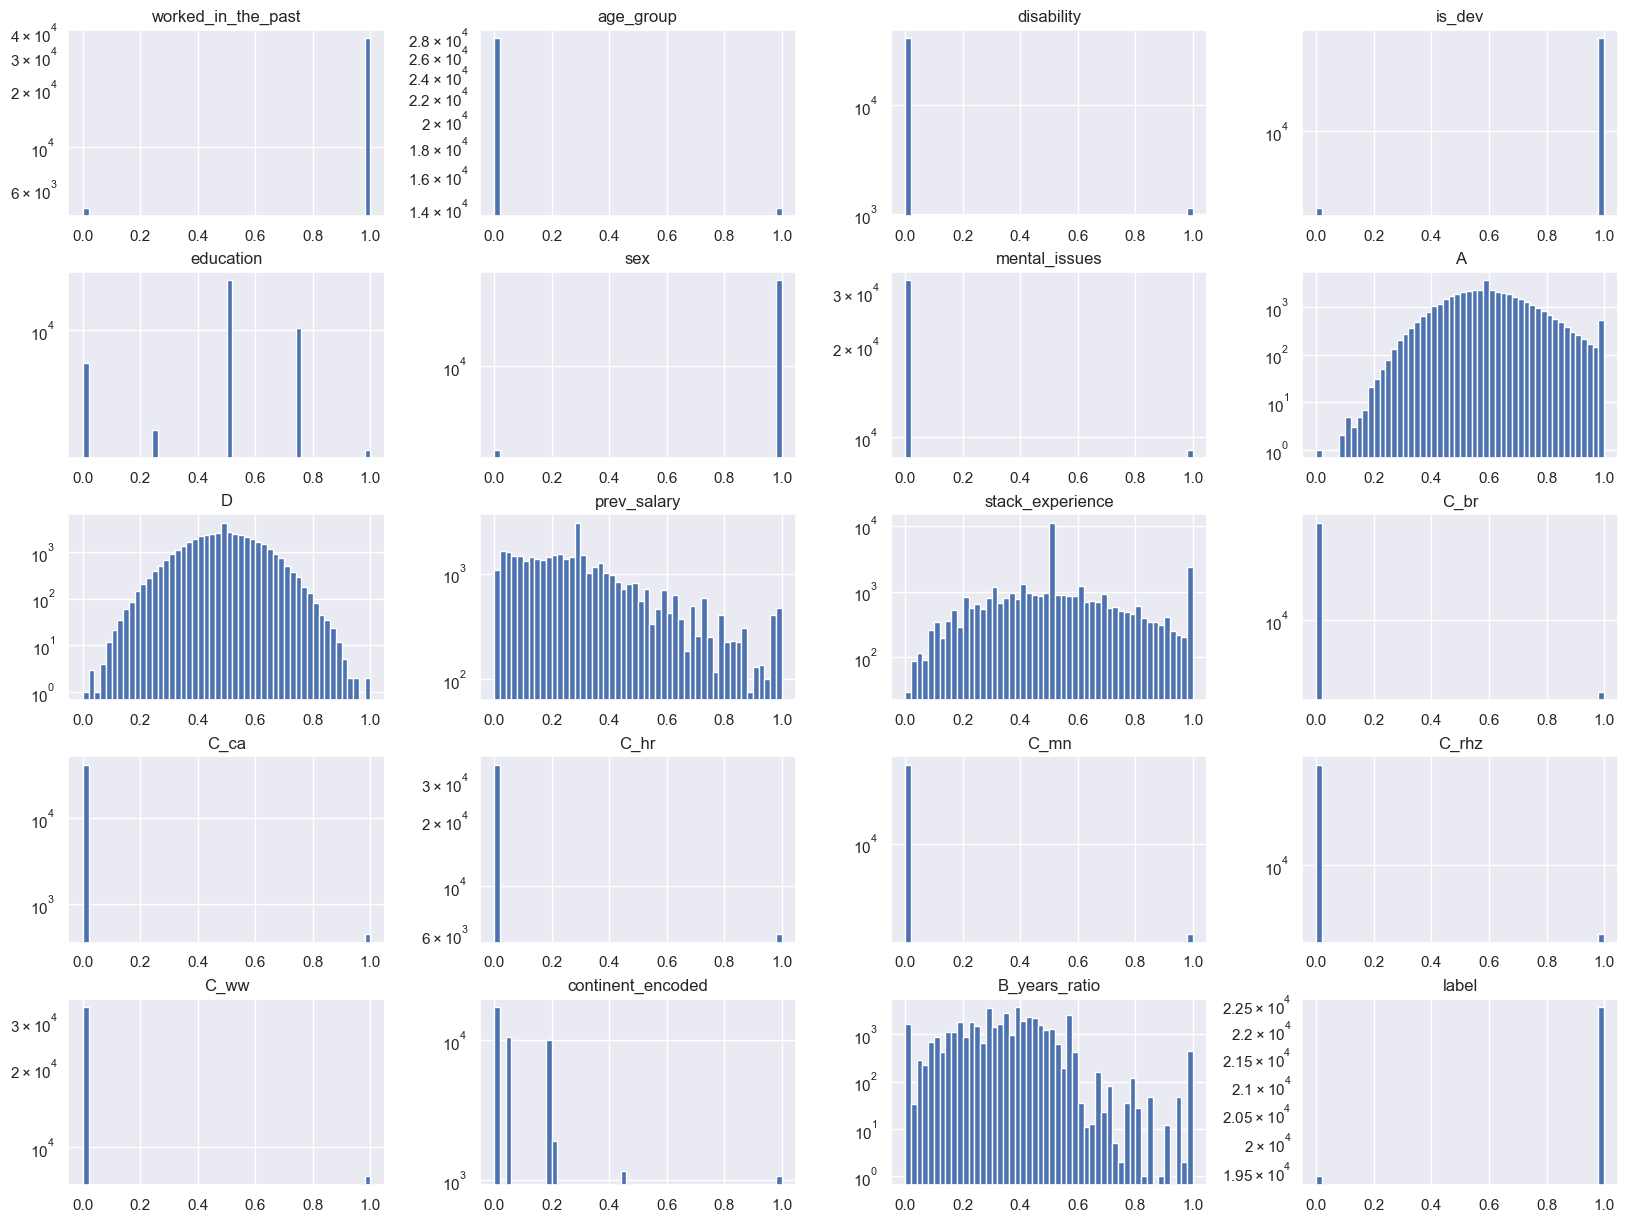

In [48]:
df_train.hist(bins=50,log=True, figsize=(20,15))
plt.show()



After applying **Min-Max normalization**, we can observe that the distribution of features like D and stack_experience remains nearly identical to their distributions after Winsorization. This consistency indicates that the relative relationships within the data have been preserved through normalization, suggesting that the normalization process was effective. The fact that the shapes of these distributions are retained implies that the Min-Max scaling did not distort the underlying data structure, allowing the model to maintain the integrity of these features while standardizing the scales across different features. This confirms that our normalization approach was well-suited for this dataset.

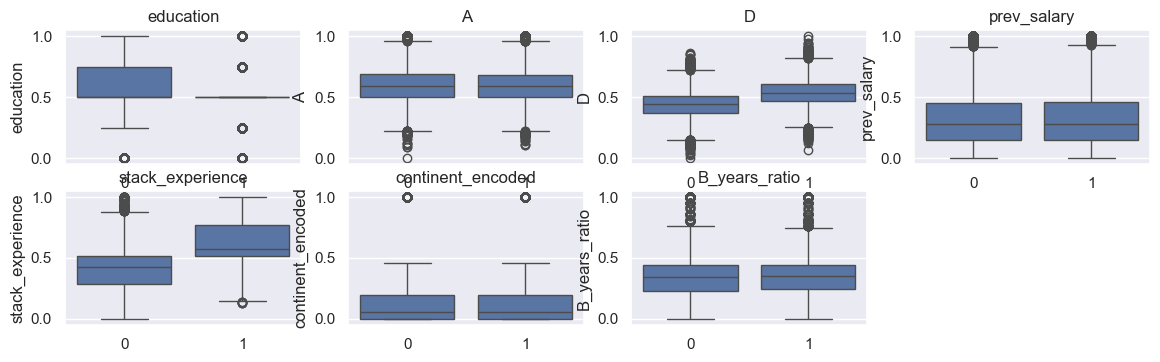

In [49]:
plt.figure(figsize=(14,8))
for i,v in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(x='label', y=v, data=df_train, showfliers=True)
    plt.xlabel('')
    plt.title(v)
plt.show()



Even after handling outliers through **Winsorization**, some data points may still appear as outliers on a Box Plot. This is because Winsorization adjusts extreme values but doesn't eliminate them, leading to some values remaining outside the typical range. Additionally, these points might represent legitimate data that naturally falls in the tails of the distribution. The Box Plot identifies outliers based on values beyond 1.5 times the interquartile range (IQR), so these points could simply reflect the expected variability in the data rather than being problematic outliers.

label
1    0.5362
0    0.4638
Name: proportion, dtype: float64


<Axes: xlabel='label'>

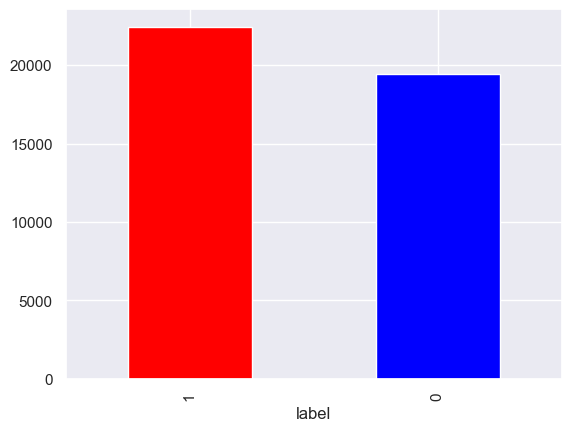

In [50]:
#barplot of the label column
print(df_train['label'].value_counts(normalize=True))
df_train['label'].value_counts().plot.bar(color=['red','blue'])

**we see that the lable still balance in the same scales.**


In [51]:
df_train.head()

worked_in_the_past  age_group  disability  is_dev  education  sex  \
3843                  1.0        1.0         0.0     1.0       0.75  1.0   
52884                 1.0        1.0         0.0     1.0       0.00  1.0   
13649                 1.0        0.0         1.0     1.0       0.50  1.0   
33106                 1.0        0.0         0.0     1.0       0.50  1.0   
10242                 1.0        1.0         0.0     1.0       0.50  1.0   

       mental_issues         A         D  prev_salary  stack_experience  C_br  \
3843             0.0  0.510363  0.658524     0.487802          0.572727   0.0   
52884            1.0  0.604894  0.470008     0.804877          0.518182   0.0   
13649            1.0  0.257518  0.455840     0.312123          0.172727   0.0   
33106            0.0  0.467828  0.578216     0.536583          0.500000   0.0   
10242            0.0  0.551585  0.575910     0.345221          0.509091   0.0   

       C_ca  C_hr  C_mn  C_rhz  C_ww  continent_encoded  B_years_ratio  label  
3843    0.0   0.0   0.0    0.0   0.0           0.197702       0.857143      0  
52884   0.0   0.0   0.0    1.0   0.0           0.197702       0.483516      1  
13649   0.0   0.0   0.0    0.0   0.0           0.000000       0.428571      0  
33106   0.0   0.0   0.0    0.0   1.0           0.197702       0.444444      1  
10242   0.0   1.0   0.0    0.0   0.0           0.458607       0.380952      0

# **Dimensionality Reduction**

Dimensionality refers to the number of features or variables used in a model. High dimensionality can present several challenges:

**Curse of Dimensionality**: As the number of dimensions (features) increases, the data becomes more sparse, meaning the distance between data points increases. This can lead to the model missing existing patterns and relationships, making it difficult for classifiers to perform well, often resulting in poor model performance.

**Computational Cost**: Higher dimensionality increases the time and resources required to process the data. The more features there are, the longer it takes to analyze and compute results, making the model computationally inefficient.

**Overfitting**: With too many features, a model can become overly complex, fitting perfectly to the training data but failing to generalize well to new, unseen data. This occurs because the model essentially "memorizes" the training data rather than learning meaningful patterns, leading to significantly reduced test accuracy.

**Identifying Dimensionality Issues:**

Run-time Computational Cost: If the model takes an excessively long time to run, it may be a sign that it is using too many features, many of which may not be necessary or helpful for the task at hand.

Model Performance: When dealing with high-dimensional data, poor model performance (such as overfitting) could indicate that the model is relying on too many features. Overfitting is common in high-dimensional spaces and should be one of the first considerations when performance is suboptimal.

Use of Validation Sets: By splitting the training set into smaller subsets, using one as a validation set while training on the others, we can evaluate the stability of the model. If the model's performance varies significantly across different validation sets, it may indicate that too many features are affecting the prediction outcome in varying ways, suggesting a potential dimensionality issue.

**In the attached report, we will delve deeper into the issue of dimensionality and the impact of the number of dimensions on models in the third section—model runs following conclusions drawn retrospectively after an initial run.**

## **PCA:**

PCA (Principal Component Analysis) is a method used for reducing the dimensionality of a problem, offering two main options:

Using a Fixed Number of Components: This approach involves selecting a specific number of features or components, determining the reduced number of dimensions you wish to achieve.

Explained Variance Percentage: In this method, you set a desired percentage of the total variance that you want the reduced data to explain. The PCA algorithm will then determine the optimal number of dimensions required to reach this explained variance.

In both options, PCA retains the most important features and constructs a model with a lower dimensionality, which is computationally more efficient. Although some information is lost in the process, the resulting model remains close in accuracy to the original model, while being faster and easier to work with.

Although it may seem like we have a large number of features, we will only be able to assess their impact on the model after comparing the performance of models run on the PCA-reduced data versus the original data. Therefore, we will address this question later using the three criteria outlined above (runtime, model performance, and validation). For now, we will prepare the PCA for running the models.

### **split the data for modeling and PCA:**

In [52]:

feature_train_columns = df_train.columns[:-1]  # All column names except the last
x_train = df_train[feature_train_columns]
y_train = df_train['label']  
x_train_reduced = x_train.copy()


**Pre Processing on Validation**

In [53]:
def pre_process_validation(df):
  df,_ = categorical_cols_handle(df, True)
  df,_ = encode_catagorial_cols(df, True)
  df = numeric_cols_handle(df)
  df = boolean_cols_handle(df)
  filtered_numerical_cols = [col for col in numerical_cols if col != 'B_years_ratio']
  df = impute_missing_values(df, filtered_numerical_cols, binary_cols)
  df = winsorize_outliers_and_plot(df, 2)
  df = add_new_corr_feature(df, "B", "years_of_experience", "B_years_ratio", True, quantile_top=0.99, quantile_bottom=0.01)
  df = min_max_normalization(df, numerical_cols, df)
  return df
df_val = main_df_val_initial.copy()
df_val = pre_process_validation(df_val)
feature_val_columns = df_val.columns[:-1]  
x_val = df_val[feature_val_columns]
y_val = df_val['label']  

x_val_reduced = x_val.copy()

df_val.head()

worked_in_the_past  age_group  disability  is_dev  education  sex  \
31604                 1.0        1.0         0.0     1.0       0.75  1.0   
30616                 1.0        1.0         0.0     1.0       0.50  1.0   
52574                 1.0        1.0         0.0     1.0       0.50  1.0   
26786                 1.0        0.0         0.0     1.0       0.50  1.0   
38639                 1.0        1.0         0.0     1.0       0.00  1.0   

       mental_issues         A         D  prev_salary  stack_experience  C_br  \
31604            0.0  0.434838  0.780320     0.477597          0.513514   0.0   
30616            0.0  0.689066  0.468296     0.432387          0.450450   0.0   
52574            0.0  0.495496  0.483009     0.491602          0.387387   0.0   
26786            0.0  0.697259  0.475175     0.271441          0.459459   0.0   
38639            0.0  0.922821  0.783412     0.349997          0.675676   0.0   

       C_ca  C_hr  C_mn  C_rhz  C_ww  continent_encoded  B_years_ratio  label  
31604   0.0   0.0   0.0    0.0   1.0           0.092253       0.000000      1  
30616   0.0   0.0   0.0    0.0   1.0           0.092253       0.861111      0  
52574   0.0   0.0   0.0    0.0   1.0           0.680595       0.000000      0  
26786   0.0   0.0   0.0    0.0   0.0           0.092253       0.425347      1  
38639   0.0   0.0   0.0    0.0   0.0           0.092253       0.555556      1

In [54]:
from sklearn.decomposition import PCA


def df_pca(df, n_components=None):
    pca = PCA(n_components=n_components)
    df_reduced = pca.fit_transform(df)
    df_reduced = pd.DataFrame(df_reduced)
    explained_variance = pca.explained_variance_ratio_
    return df_reduced, explained_variance, pca

In [55]:
#do PCA on the training
print("Before PCA = ", df_train.shape)
x_train_reduced, explained_train_var,pca = df_pca(x_train,0.95)
print("After PCA = ", x_train_reduced.shape)
print(f'We need {pca.n_components_} components to explain 95% of the variance')

x_val_reduced = pca.transform(x_val)
x_val_reduced = pd.DataFrame(x_val_reduced)


Before PCA =  (41865, 20)
After PCA =  (41865, 15)
We need 15 components to explain 95% of the variance


we see that we can explain 95% of the variance by 15 features,the curve shows that it maybe provides a good balance between dimensionality reduction and retaining the original data's variability.

In [56]:
x_val_reduced.head()

0         1         2         3         4         5         6   \
0  0.611748 -0.159367  0.828020  0.237349 -0.191730 -0.040865 -0.034421   
1  0.700369 -0.147872  0.829187  0.230498 -0.162856 -0.038748 -0.150484   
2  0.609559 -0.121580  0.826490  0.234187 -0.165082 -0.041440 -0.107153   
3 -0.319297 -0.246855 -0.078657 -0.119287 -0.099168  0.022379 -0.060487   
4  0.653588 -0.141247 -0.054592 -0.120193 -0.076657  0.014973 -0.369014   

         7         8         9         10        11        12        13  \
0 -0.068733  0.187125 -0.116395 -0.082207 -0.112932  0.052068  0.012832   
1 -0.088643 -0.004924  0.012197 -0.022395  0.098341  0.029485 -0.016655   
2 -0.092050 -0.002411  0.006507  0.009561  0.136500  0.059094  0.564571   
3  0.158628 -0.019049 -0.032787 -0.027093  0.076823 -0.173107 -0.001945   
4  0.104830 -0.437940  0.217461  0.109116 -0.092308 -0.158528 -0.049599   

         14  
0 -0.027334  
1 -0.013136  
2 -0.045092  
3 -0.004132  
4 -0.038320

In [57]:
x_train_reduced.head()

0         1         2         3         4         5         6   \
0  0.747451 -0.197026 -0.050161 -0.103540 -0.192113  0.016637 -0.098731   
1  0.681476  0.891020 -0.206206 -0.477399 -0.112053 -0.680836 -0.293935   
2 -0.357847  0.777049 -0.127622 -0.097079 -0.093516  0.036887  0.021833   
3 -0.298180 -0.185673  0.802801  0.219726 -0.123095 -0.027753 -0.088982   
4  0.658644 -0.209096 -0.502596  0.700838 -0.125358 -0.060513 -0.147699   

         7         8         9         10        11        12        13  \
0  0.177451  0.155069 -0.125290  0.067028 -0.067203 -0.164215  0.105156   
1 -0.368789 -0.249792  0.005212  0.270790  0.292588  0.096778 -0.042301   
2  0.171196  0.012813 -0.089669 -0.263619  0.260780 -0.172094 -0.048007   
3 -0.079299  0.064554 -0.092634  0.220510  0.172027  0.037465  0.042363   
4 -0.140776 -0.046314  0.025582 -0.029784 -0.025347  0.076811  0.360906   

         14  
0 -0.012625  
1 -0.061266  
2  0.964385  
3 -0.003156  
4 -0.042405

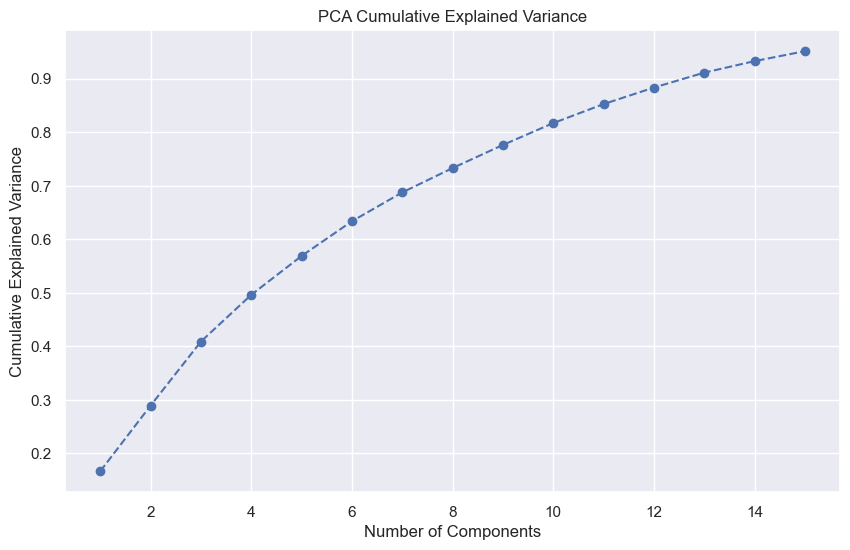

In [58]:
cumulative_explained_variance = np.cumsum(explained_train_var)

# Plot the PCA curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.show()



In [59]:
print(f"Original X_train shape: {x_train.shape}")
print(f"Reduced X_train shape: {x_train_reduced.shape}")
assert np.array_equal(x_train, df_train.iloc[:, :-1].values), "Train data mismatch!"
assert np.array_equal(y_train, df_train['label'].values), "Train labels mismatch!"
assert np.array_equal(x_val, df_val.iloc[:, :-1].values), "Validation data mismatch!"
assert np.array_equal(y_val, df_val['label'].values), "Validation labels mismatch!"

Original X_train shape: (41865, 19)
Reduced X_train shape: (41865, 15)


# **Part 3** - **MODELS**


# **KNN** **& Bayes**




## **KNN**

The KNN (K-Nearest Neighbors) model is used for classification and regression tasks by predicting the label of a new data point based on the labels of its closest neighbors in the training data. In this analysis, we evaluated the model performance with different values of the hyperparameter  k, which represents the number of neighbors considered.



In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

def kNN_classifier_full_process(X_train, y_train, X_val, y_val, k_values):
    # Ensure X_train, y_train, X_val, y_val are numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)

    train_mse_scores = []
    val_mse_scores = []
    auc_scores = []

    # Loop over all k values to find the best one
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Predict and calculate MSE for training and validation sets
        y_train_pred = knn.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_mse_scores.append(train_mse)

        y_val_pred = knn.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_mse_scores.append(val_mse)

        # Calculate AUC on validation set
        y_scores = knn.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_scores)
        auc_scores.append(auc(fpr, tpr))

    # Identify the best k based on validation MSE
    best_k = k_values[np.argmin(val_mse_scores)]

    # Plot MSE scores
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, train_mse_scores, label='Train MSE', marker='o')
    plt.plot(k_values, val_mse_scores, label='Validation MSE', marker='x')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('KNN Classifier MSE Performance')
    plt.xticks(k_values)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Re-evaluate the model using K-Fold cross-validation with the best k
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_aucs = []

    plt.figure(figsize=(20, 8))
    for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
        X_val_fold, y_val_fold = X_train[val_index], y_train[val_index]

        best_knn.fit(X_train_fold, y_train_fold)
        y_scores = best_knn.predict_proba(X_val_fold)[:, 1]

        fpr, tpr, _ = roc_curve(y_val_fold, y_scores)
        fold_auc = auc(fpr, tpr)
        fold_aucs.append(fold_auc)

        plt.plot(fpr, tpr, label=f'Fold {fold_idx+1} AUC = {fold_auc:.4f}')

    average_auc = np.mean(fold_aucs)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for Best k={best_k} (5-Fold CV, Avg AUC = {average_auc:.4f})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f'Best k: {best_k}')
    print(f'Validation MSE with best k: {np.min(val_mse_scores):.4f}')
    print(f'Average AUC across folds: {average_auc:.4f}')
    print(f'AUC on validation set with best k={best_k}: {auc_scores[k_values.index(best_k)]:.4f}')





**KNN on Original Data**

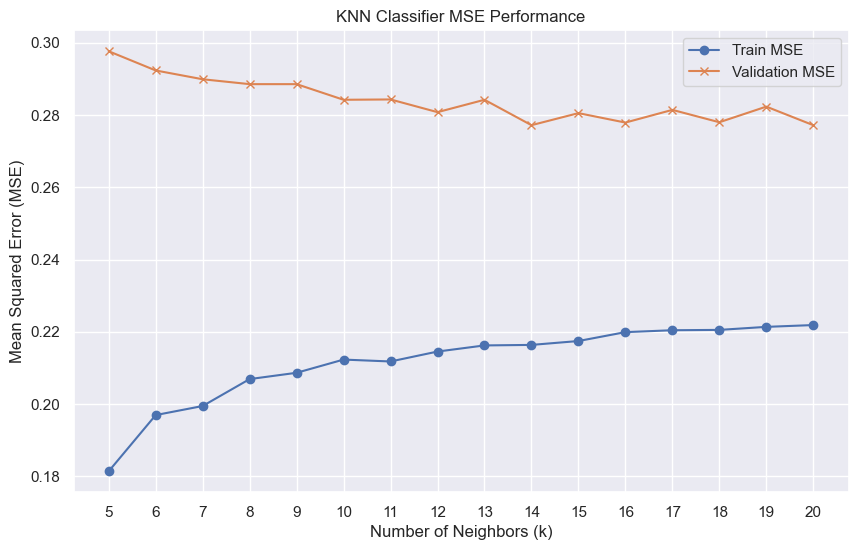

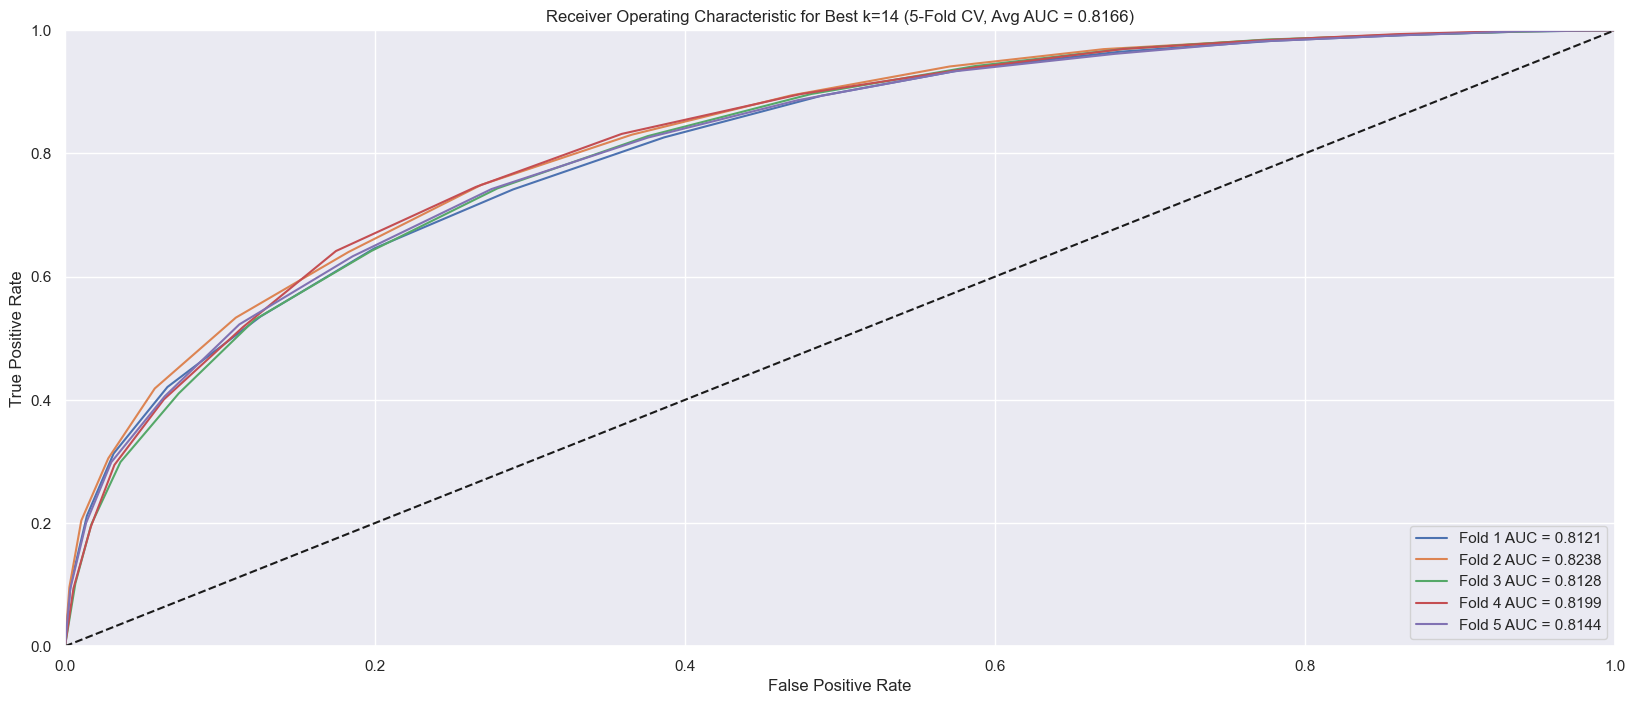

Best k: 14
Validation MSE with best k: 0.2772
Average AUC across folds: 0.8166
AUC on validation set with best k=14: 0.8024


In [61]:

kNN_classifier_full_process(X_train=x_train, y_train=y_train, X_val=x_val,y_val=y_val, k_values=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])


**KNN on Reduced Data With PCA**

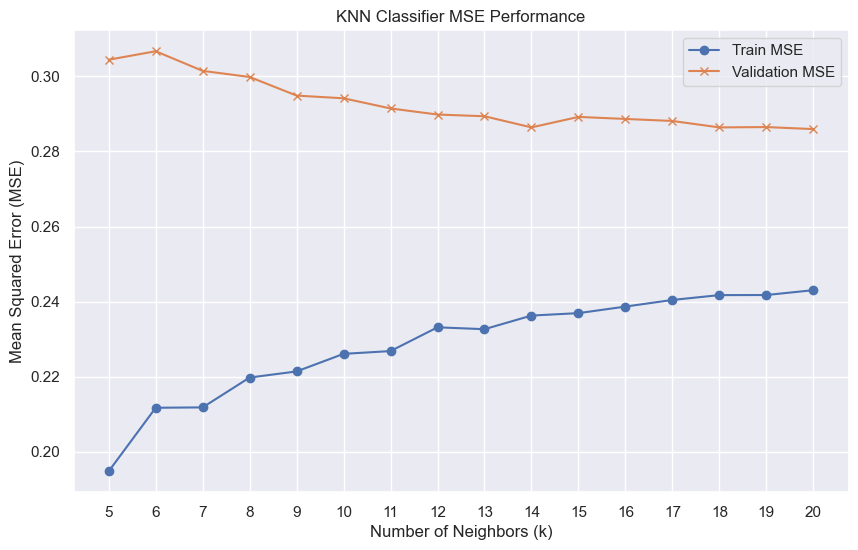

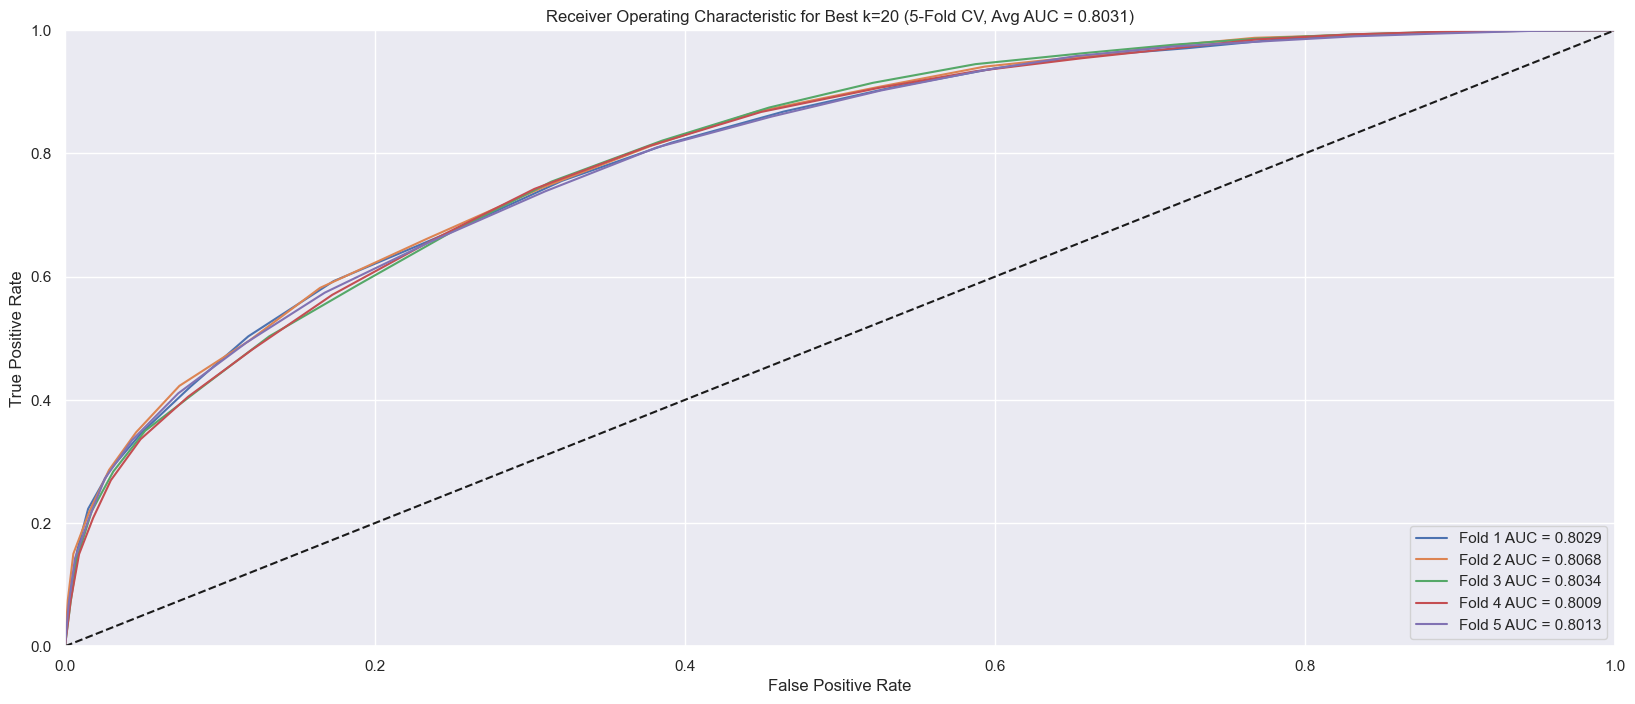

Best k: 20
Validation MSE with best k: 0.2859
Average AUC across folds: 0.8031
AUC on validation set with best k=20: 0.7981


In [62]:

kNN_classifier_full_process(x_train_reduced, y_train, x_val_reduced, y_val, [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

After running tests with  k ranging from 5 to 20, we found that the optimal number of neighbors is 14, based on the lowest Mean Squared Error (MSE) on the validation set. Specifically, the model achieved a validation MSE of 0.2772 with k=14, indicating good performance. The average AUC (Area Under the Curve) across 5-fold cross-validation was 0.8166, demonstrating the model's ability to differentiate between classes effectively. Additionally, the AUC on the validation set with k=14 was slightly lower at 0.8024.

The analysis of the MSE curves shows that as the number of neighbors increases, the variance decreases up to a certain point (around k=14), after which it starts to increase again, indicating the optimal balance between variance and bias. Although there is a slight overfitting observed, the difference between the training and validation MSE is relatively small (about 0.05), suggesting that the model is not excessively overfitting.

After applying PCA and reducing the dimensionality, the optimal k value shifted to 20, with an average AUC of 0.8031. Although the validation MSE with k=20 was relatively low (0.2859), there was a slight decrease in performance compared to the model without PCA, particularly as the AUC on the validation set dropped to 0.7981.

Overall, these results suggest that while dimensionality reduction using PCA can lead to changes in model performance, in this case, the model without PCA slightly outperforms the PCA model, albeit with an increased risk of overfitting.


# **Naive Bayes**

In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

def naive_bayes_full_process(X_train, y_train, X_val, y_val):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # Initialize the Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Predict on training and validation sets
    y_train_pred = nb_model.predict(X_train)
    y_val_pred = nb_model.predict(X_val)

    # Calculate MSE for training and validation sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    print(f'Train MSE: {train_mse:.2f}, Validation MSE: {val_mse:.2f}')
    # Plotting the MSE values
    plt.figure(figsize=(6, 4))
    mse_values = [train_mse, val_mse]
    labels = ['Train', 'Validation']
    plt.bar(labels, mse_values, color=['blue', 'orange'])
    plt.xlabel('Dataset')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error Comparison')
    plt.show()

    # Evaluating AUC on validation set
    y_scores_val = nb_model.predict_proba(X_val)[:, 1]
    fpr_val, tpr_val, _ = roc_curve(y_val, y_scores_val)
    roc_auc_val = auc(fpr_val, tpr_val)
    print(f'AUC on Validation Set: {roc_auc_val:.4f}')

    # Perform 5-Fold Cross-Validation to evaluate model
    kf = KFold(n_splits=5, shuffle=True, random_state=69)
    auc_scores = []
    plt.figure(figsize=(10, 6))

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_train_val = y_train[train_index], y_train[val_index]

        nb_model.fit(X_train_fold, y_train_fold)
        y_scores_fold = nb_model.predict_proba(X_val_fold)[:, 1]

        fpr, tpr, _ = roc_curve(y_train_val, y_scores_fold)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)

        plt.plot(fpr, tpr, label=f'Fold {train_index[0]}-{train_index[-1]} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (5-Fold Cross-Validation)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f'Average AUC across folds: {np.mean(auc_scores):.4f}')



Train MSE: 0.25, Validation MSE: 0.28


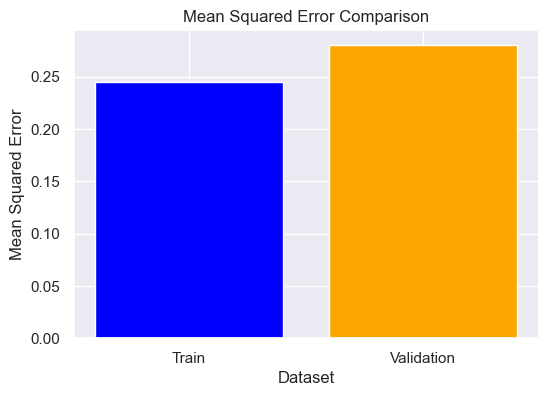

AUC on Validation Set: 0.8090


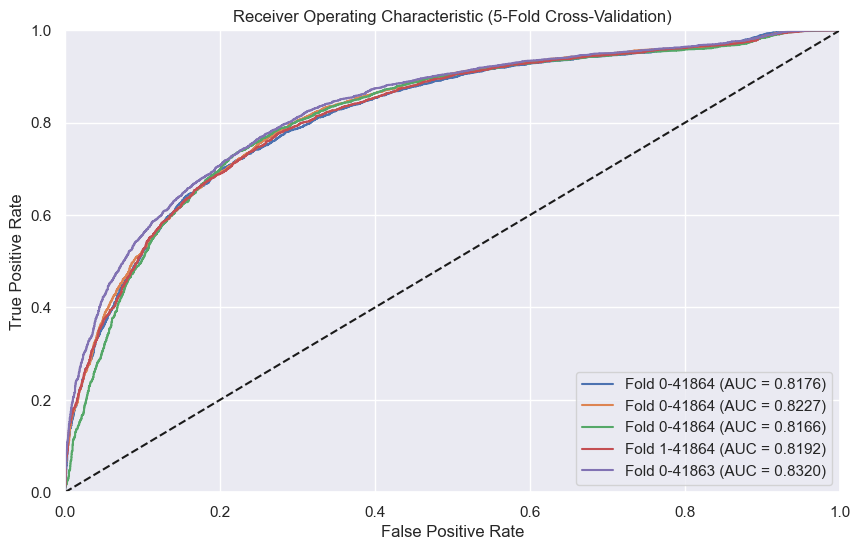

Average AUC across folds: 0.8216


In [64]:
naive_bayes_full_process(x_train, y_train, x_val, y_val)

Train MSE: 0.27, Validation MSE: 0.31


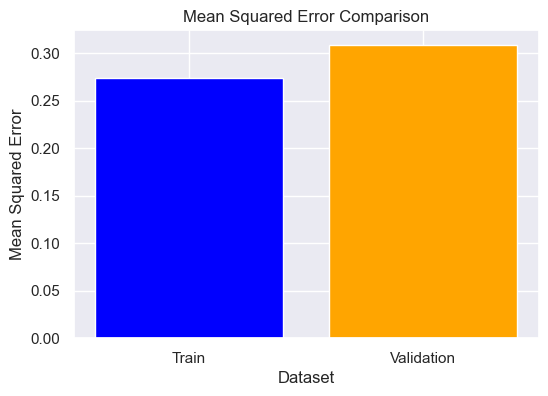

AUC on Validation Set: 0.7677


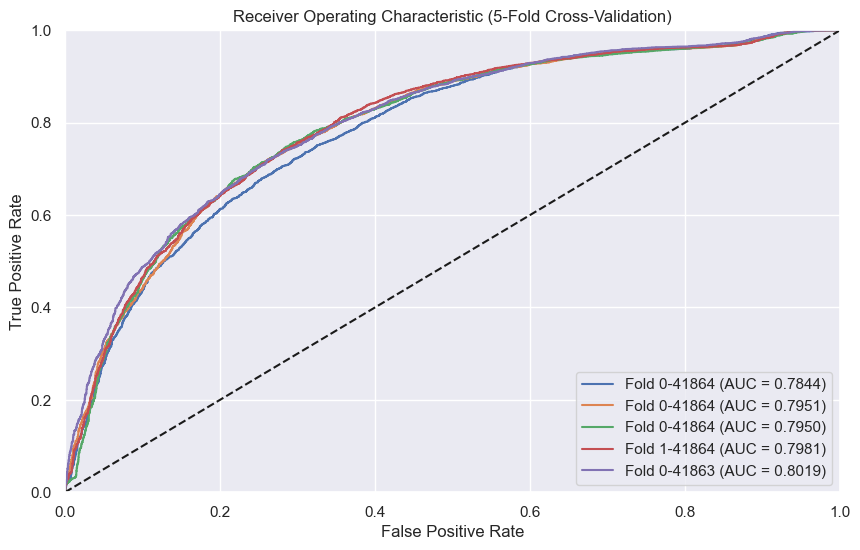

Average AUC across folds: 0.7949


In [65]:
naive_bayes_full_process(x_train_reduced, y_train, x_val_reduced, y_val)

# **Decision Tree**

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Ensure you have pandas imported if you're using DataFrame and Series

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

def decision_tree_full_process(X_train, y_train, X_val, y_val, max_depth_values):
    # Ensure we're working with numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)

    train_accuracy_scores = []
    val_accuracy_scores = []
    auc_scores_val = []

    # Loop over all max_depth values to find the best one
    for max_depth in max_depth_values:
        dt = DecisionTreeClassifier(max_depth=max_depth, random_state=69)
        dt.fit(X_train, y_train)

        # Predict and calculate accuracy for training and validation sets
        y_train_pred = dt.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_accuracy_scores.append(train_accuracy)

        y_val_pred = dt.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_accuracy_scores.append(val_accuracy)

        # Calculate AUC on validation set
        y_scores_val = dt.predict_proba(X_val)[:, 1]
        fpr_val, tpr_val, _ = roc_curve(y_val, y_scores_val)
        auc_val = auc(fpr_val, tpr_val)
        auc_scores_val.append(auc_val)

        

    # Identify the best max_depth based on validation accuracy
    best_max_depth = max_depth_values[np.argmax(val_accuracy_scores)]

    # Plot accuracy scores
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_values, train_accuracy_scores, label='Train Accuracy', marker='o')
    plt.plot(max_depth_values, val_accuracy_scores, label='Validation Accuracy', marker='x')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy Performance')
    plt.xticks(max_depth_values)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform K-Fold cross-validation using the best max_depth
    best_dt = DecisionTreeClassifier(max_depth=best_max_depth, random_state=69)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_aucs = []

    plt.figure(figsize=(10, 6))
    for fold_idx, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_train_fold, y_train_fold = X_train[train_index], y_train[train_index]
        X_val_fold, y_val_fold = X_train[val_index], y_train[val_index]

        best_dt.fit(X_train_fold, y_train_fold)
        y_scores_fold = best_dt.predict_proba(X_val_fold)[:, 1]
        fpr, tpr, _ = roc_curve(y_val_fold, y_scores_fold)
        fold_auc = auc(fpr, tpr)
        fold_aucs.append(fold_auc)

        plt.plot(fpr, tpr, label=f'Fold {fold_idx+1} AUC = {fold_auc:.4f}')

    average_auc = np.mean(fold_aucs)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for Best Max Depth={best_max_depth} (5-Fold CV, Avg AUC = {average_auc:.4f})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Print results
    print(f'Best max depth: {best_max_depth}')
    print(f'Validation Accuracy with best max depth: {np.max(val_accuracy_scores):.4f}')
    print(f'Validation AUC with best max depth: {auc_scores_val[np.argmax(val_accuracy_scores)]:.4f}')
    print(f'Average AUC across folds: {average_auc:.4f}')

**DT on original data**

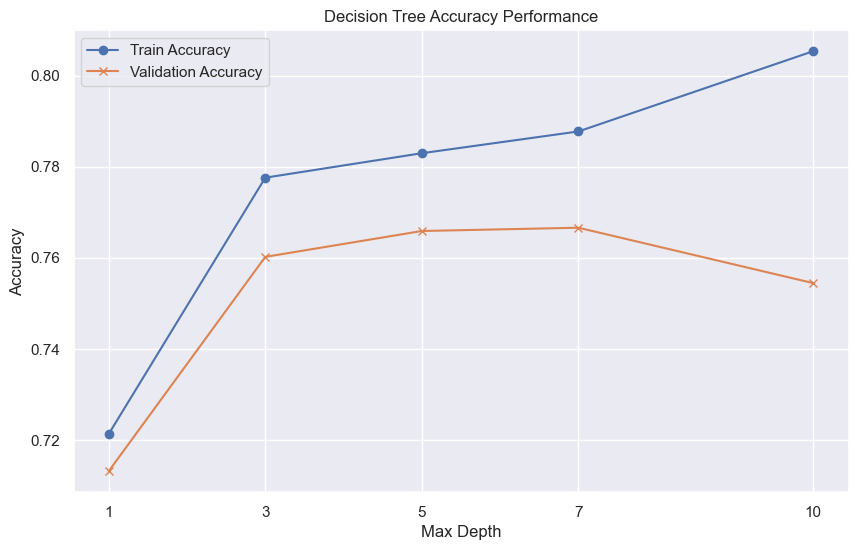

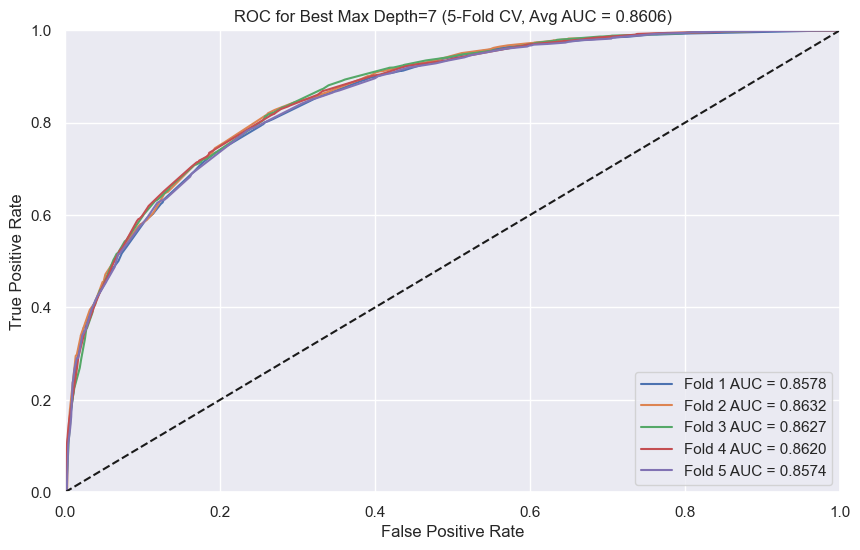

Best max depth: 7
Validation Accuracy with best max depth: 0.7666
Validation AUC with best max depth: 0.8576
Average AUC across folds: 0.8606


In [67]:
max_depth_values = [ 1,3,5,7,10]
decision_tree_full_process(x_train, y_train, x_val, y_val, max_depth_values)

**DT on PCA**

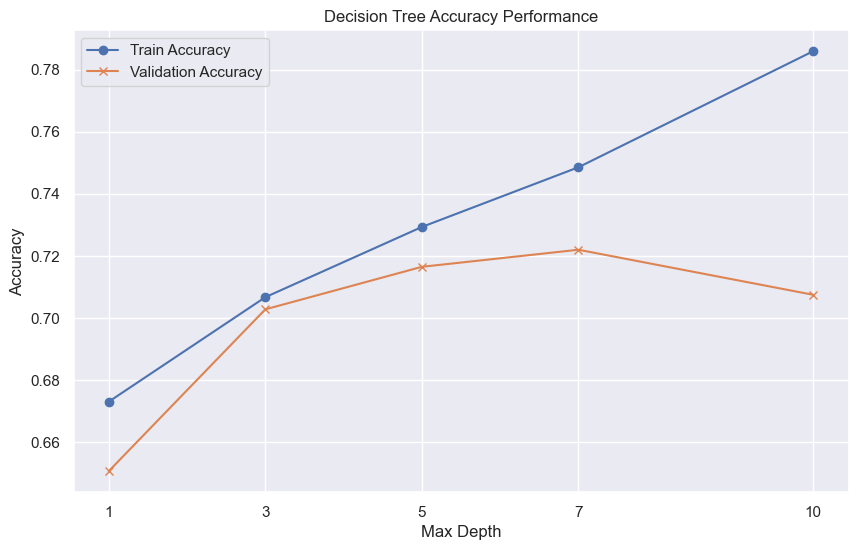

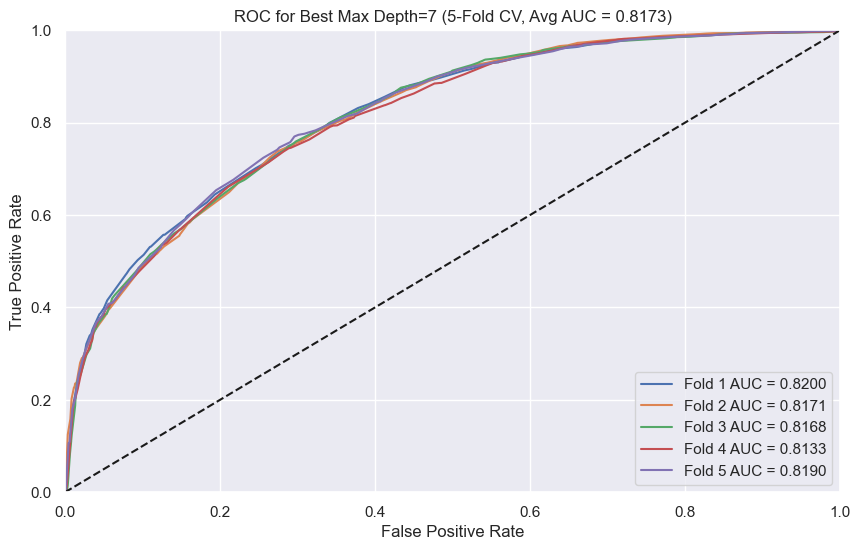

Best max depth: 7
Validation Accuracy with best max depth: 0.7220
Validation AUC with best max depth: 0.8092
Average AUC across folds: 0.8173


In [68]:
max_depth_values = [1,3,5,7,10]
decision_tree_full_process(x_train_reduced, y_train, x_val_reduced, y_val, max_depth_values)

The analysis of the decision tree model's performance with and without PCA reveals important insights about the impact of the max_depth hyperparameter and the balance between variance and bias.

The graphs illustrate how varying the max_depth **Hyperparameter** in decision tree models influences performance. The max_depth controls the tree's complexity by determining how deep it can grow. Without PCA, the model achieves its best performance at a max_depth of 5, where the validation Mean Squared Error (MSE) is 0.2314 and the average Area Under the Curve (AUC) across five-fold cross-validation is 0.8609. As the max_depth increases, the training MSE decreases, reflecting an improved fit to the training data. However, the validation MSE increases, indicating overfitting—where the model captures noise and thus struggles to generalize to new data. The AUC for max_depth=5 on the validation set is 0.8581, showing good generalization.

With PCA applied, there is a slight reduction in model performance. The validation MSE at max_depth=5 becomes 0.2315, and the average AUC across folds decreases to 0.8080. Although similar overfitting behavior is observed, it is less pronounced when PCA is used. In other words, the gap between the training MSE and the validation MSE is smaller compared to the model without PCA. This suggests that the use of PCA has helped reduce overfitting and improved the model's generalization ability. However, the slightly lower AUC suggests that PCA may have caused some loss of important information, indicating a trade-off, and also there is no significant differnce in deph of 5.

Bias-Variance Trade-off:
As the max_depth increases, the variance of the model also increases, allowing it to better fit the training data but reducing its ability to generalize due to overfitting. On the other hand, deeper trees reduce bias by capturing more patterns within the data, yet this often leads to overfitting. Overall, a max_depth of 5 strikes a good balance between variance and bias, minimizing overfitting while maintaining solid performance. PCA, while helping to reduce overfitting, slightly lowers the model's performance, demonstrating the trade-off between reducing variance and retaining important information.

**The Chosen Model** - Random Forest

צריך לשנות את ההסבר על המודללללללללל כי החלפנווווווו
In the model we examined, we decided to tune several hyperparameters to improve the accuracy of the results. Specifically, we focused on adjusting the learning rate (learning_rate) and the number of estimators (n_estimators) to find the optimal configuration. Additionally, we performed five-fold cross-validation to evaluate the model's performance.

The results showed that the model with the best hyperparameters (learning_rate=0.1 and n_estimators=100) achieved an average AUC of 0.8716 across the five cross-validation folds, indicating strong discriminative ability between classes. On the validation set, the AUC was slightly lower at 0.8680 but still high, reflecting good generalization of the model.

In the additional graph, we can observe that the model maintains a good balance between bias and variance, with a small difference between the AUC on the training and validation sets. This suggests that the model is not overfitting.

The results showed that the model with the best hyperparameters (learning_rate=0.1 and n_estimators=800) achieved an average AUC of 0.8716 across the five cross-validation folds, indicating strong discriminative ability between classes. On the validation set, the AUC was slightly lower at 0.8680 but still high, reflecting good generalization of the model.

In the additional graph, we can observe that the model maintains a good balance between bias and variance, with a small difference between the AUC on the training and validation sets. This suggests that the model is not overfitting.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_curve, auc, accuracy_score

def randomForest(state, X_train, Y_train, X_val, Y_val):
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)

    # Parameters for RandomForest
    hyperparameters = {
        'criterion': 'entropy',
        'max_depth': None,  # Will be varied in the loop
        'max_leaf_nodes': 650,
        'min_samples_leaf': 1,
        'min_samples_split': 3,
        'n_estimators': 600
    }

    # Define the range of max_depth values to explore
    max_depth_values = [5,10, 20, 35]

    # Initialize variables for storing results
    train_accuracies = []
    val_accuracies = []

    # Loop over each max_depth to calculate accuracies directly
    for depth in max_depth_values:
        hyperparameters['max_depth'] = depth
        rf_model = RandomForestClassifier(**hyperparameters, random_state=state)
        rf_model.fit(X_train, Y_train)

        y_train_pred = rf_model.predict(X_train)
        y_val_pred = rf_model.predict(X_val)

        train_accuracy = accuracy_score(Y_train, y_train_pred)
        val_accuracy = accuracy_score(Y_val, y_val_pred)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_values, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(max_depth_values, val_accuracies, label='Validation Accuracy', marker='x')
    plt.title('Random Forest Accuracy vs Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform GridSearchCV to find the best overall parameters
    best_model = RandomForestClassifier(random_state=state)
    param_grid = {
        'max_depth': max_depth_values,
        'n_estimators': [600],
        'criterion': ['entropy'],
        'min_samples_leaf': [1],
        'min_samples_split': [3],
        'max_leaf_nodes': [650]
    }
    gscv = GridSearchCV(best_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    gscv.fit(X_train, Y_train)
    best_params = gscv.best_params_

    print(f"Best parameters from GridSearch: {best_params}")

    # Re-evaluate the model with the best parameters found
    best_model.set_params(**best_params)
    best_model.fit(X_train, Y_train)

    kf = KFold(n_splits=5, shuffle=True, random_state=state)
    auc_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, y_train_fold = X_train[train_index], Y_train[train_index]
        X_val_fold, y_val_fold = X_train[val_index], Y_train[val_index]

        best_model.fit(X_train_fold, y_train_fold)
        y_scores_fold = best_model.predict_proba(X_val_fold)[:, 1]
        fpr, tpr, _ = roc_curve(y_val_fold, y_scores_fold)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, label=f'Fold {train_index[0]}-{train_index[-1]} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Random Forest with Best Parameters')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f'Average AUC across folds: {np.mean(auc_scores):.4f}')

    # Final evaluation on the validation set
    y_val_scores = best_model.predict_proba(X_val)[:, 1]
    print(y_val_scores)
    fpr_val, tpr_val, _ = roc_curve(Y_val, y_val_scores)
    test_auc = auc(fpr_val, tpr_val)

    print(f'Test AUC on validation set: {test_auc:.4f}')

    return gscv, best_params, best_model

# Example usage:
# gscv, best_params, best_model = randomForest_new(42, X_train, Y_train, X_val, Y_val)


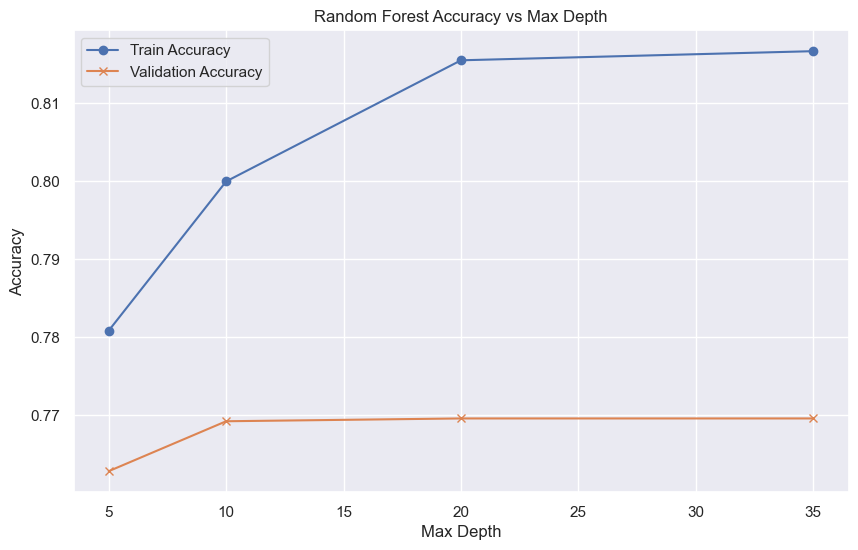

Best parameters from GridSearch: {'criterion': 'entropy', 'max_depth': 35, 'max_leaf_nodes': 650, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600}


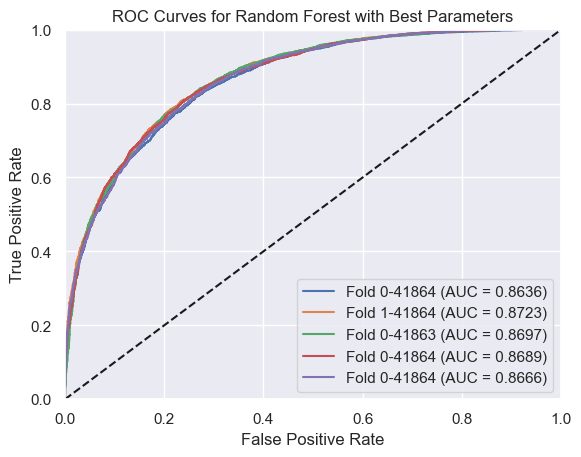

Average AUC across folds: 0.8682
[0.78230863 0.46705707 0.38282447 ... 0.8703294  0.45895715 0.92263426]
Test AUC on validation set: 0.8633


In [70]:
gscv, best_params, best_model = randomForest(42, x_train, y_train, x_val, y_val)

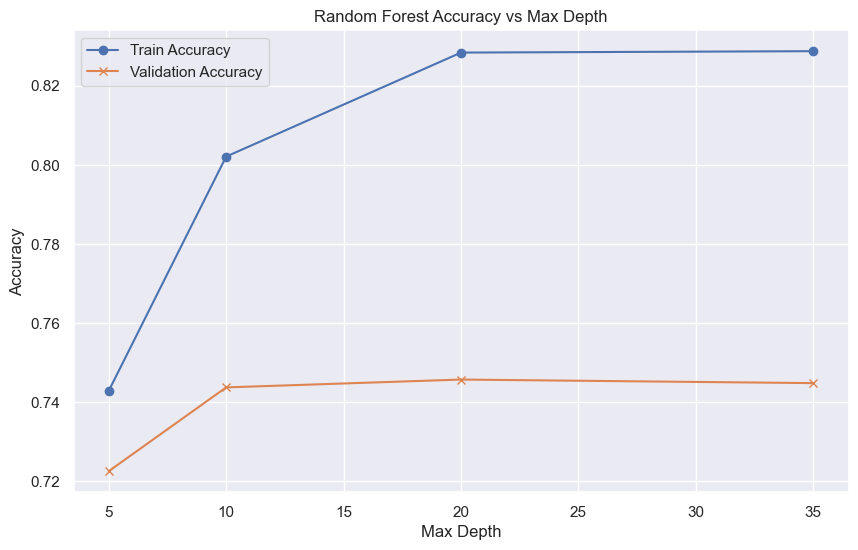

Best parameters from GridSearch: {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 650, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600}


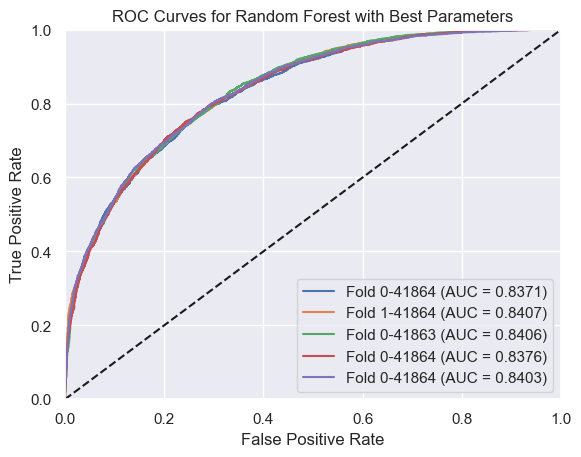

Average AUC across folds: 0.8392
[0.57654432 0.50915378 0.40744573 ... 0.84706953 0.15786988 0.973875  ]
Test AUC on validation set: 0.8359


In [71]:
gscv_2,best_params_2,best_model_2= randomForest(42, x_train_reduced, y_train, x_val_reduced, y_val)

we see overfitting at the original data from maxdepth=10, so we will run the model with limit of maxdepth=10 to handle the overfitting 

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_curve, auc, accuracy_score

def randomForest_no_overfit(state, X_train, Y_train, X_val, Y_val):
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)

    # Parameters for RandomForest
    hyperparameters = {
        'criterion': 'entropy',
        'max_depth': None,  # Will be varied in the loop
        'max_leaf_nodes': 650,
        'min_samples_leaf': 1,
        'min_samples_split': 3,
        'n_estimators': 600
    }

    # Define the range of max_depth values to explore
    max_depth_values = [5,10]

    # Initialize variables for storing results
    train_accuracies = []
    val_accuracies = []

    # Loop over each max_depth to calculate accuracies directly
    for depth in max_depth_values:
        hyperparameters['max_depth'] = depth
        rf_model = RandomForestClassifier(**hyperparameters, random_state=state)
        rf_model.fit(X_train, Y_train)

        y_train_pred = rf_model.predict(X_train)
        y_val_pred = rf_model.predict(X_val)

        train_accuracy = accuracy_score(Y_train, y_train_pred)
        val_accuracy = accuracy_score(Y_val, y_val_pred)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(max_depth_values, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(max_depth_values, val_accuracies, label='Validation Accuracy', marker='x')
    plt.title('Random Forest Accuracy vs Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform GridSearchCV to find the best overall parameters
    best_model = RandomForestClassifier(random_state=state)
    param_grid = {
        'max_depth': max_depth_values,
        'n_estimators': [600],
        'criterion': ['entropy'],
        'min_samples_leaf': [1],
        'min_samples_split': [3],
        'max_leaf_nodes': [650]
    }
    gscv = GridSearchCV(best_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    gscv.fit(X_train, Y_train)
    best_params = gscv.best_params_

    print(f"Best parameters from GridSearch: {best_params}")

    # Re-evaluate the model with the best parameters found
    best_model.set_params(**best_params)
    best_model.fit(X_train, Y_train)

    kf = KFold(n_splits=5, shuffle=True, random_state=state)
    auc_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, y_train_fold = X_train[train_index], Y_train[train_index]
        X_val_fold, y_val_fold = X_train[val_index], Y_train[val_index]

        best_model.fit(X_train_fold, y_train_fold)
        y_scores_fold = best_model.predict_proba(X_val_fold)[:, 1]
        fpr, tpr, _ = roc_curve(y_val_fold, y_scores_fold)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, label=f'Fold {train_index[0]}-{train_index[-1]} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Random Forest with Best Parameters')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f'Average AUC across folds: {np.mean(auc_scores):.4f}')

    # Final evaluation on the validation set
    y_val_scores = best_model.predict_proba(X_val)[:, 1]
    print(y_val_scores)
    fpr_val, tpr_val, _ = roc_curve(Y_val, y_val_scores)
    test_auc = auc(fpr_val, tpr_val)

    print(f'Test AUC on validation set: {test_auc:.4f}')

    return gscv, best_params, best_model




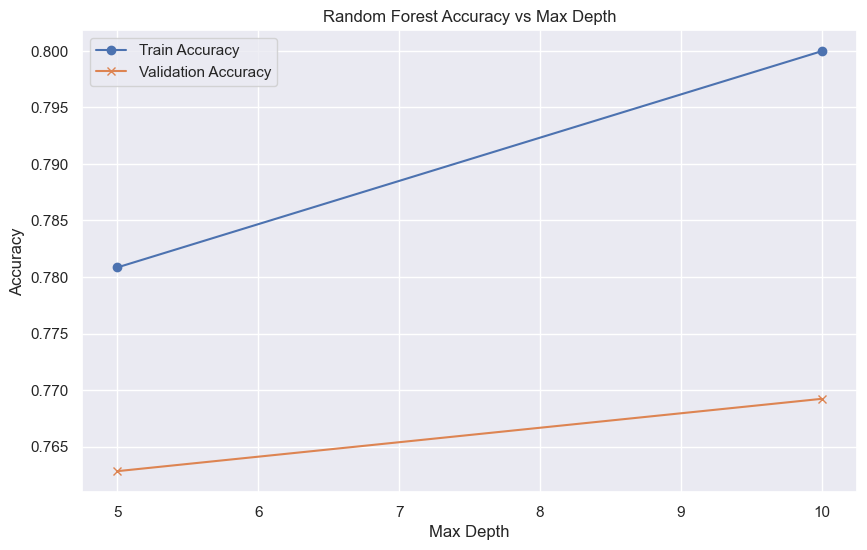

Best parameters from GridSearch: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 650, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600}


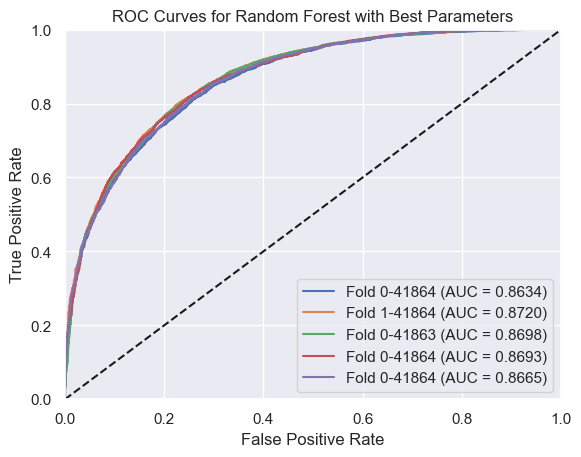

Average AUC across folds: 0.8682
[0.768877   0.44856198 0.37528742 ... 0.87625795 0.47044872 0.93396244]
Test AUC on validation set: 0.8638


In [73]:
gscv_3, best_params_3, best_model_3 = randomForest_no_overfit(42, x_train, y_train, x_val, y_val)

## **Feature importance**

feature importance for PCA data 

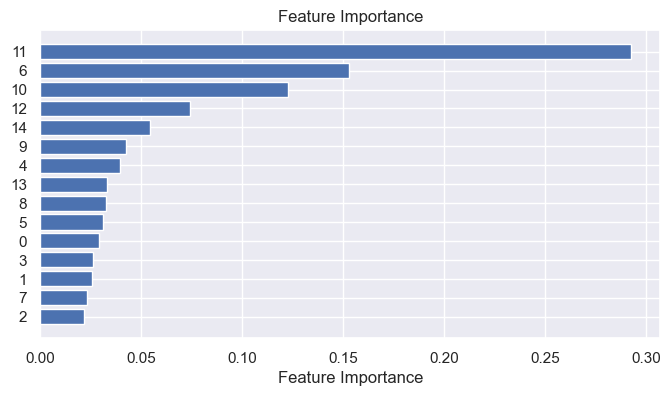

array([0.02902457, 0.02579251, 0.02171552, 0.02635504, 0.03939303,
       0.03086729, 0.15259225, 0.02316036, 0.03259726, 0.04246199,
       0.12256774, 0.29218095, 0.07398444, 0.03320321, 0.05410385])

In [74]:
#plot the feature importance of the best model in descending order
feature_importance_2 = gscv_2.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance_2)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance_2[sorted_idx], align='center')
plt.yticks(pos, x_train_reduced.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')#
plt.show()
feature_importance_2

Feature importance for chosen model

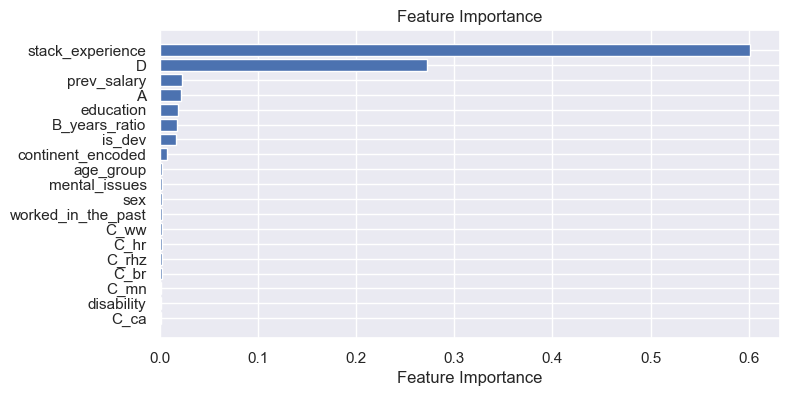

array([0.00236117, 0.00272907, 0.0015244 , 0.01606864, 0.01890659,
       0.00239978, 0.00266534, 0.02186292, 0.27212895, 0.02224055,
       0.60161729, 0.00174874, 0.00090144, 0.00195654, 0.00169376,
       0.00182018, 0.00208121, 0.00729185, 0.01800156])

In [75]:
#plot the feature importance of the best model in descending order
feature_importance_3 = gscv_3.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance_3)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance_3[sorted_idx], align='center')
plt.yticks(pos, df_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')#
plt.show()
feature_importance_3

we see a lot of features that have low importance so intuative we can assume that we can reduce those features and thats wont harm the model, but we chose to reduce features until we get 15 features in the df and by that not to simplify the model too nuch but also handle the high dimensions, the motivate to do that came from df_reduce shape after PCA 

Lets create new DF with only important features, the number of feature has decide by the number of features that the PCA reduced - 15 

In [76]:
best_features = 15
important_features_3 = df_train.columns[np.argsort(feature_importance_3)[::-1]][:best_features]
df_train_best_features = df_train[important_features_3]
df_train_best_features["label"] = df_train["label"]
df_val_best_features = df_val[important_features_3]
df_val_best_features["label"] = df_val["label"]
df_train_best_features.head()

stack_experience         D  prev_salary         A  education  \
3843           0.572727  0.658524     0.487802  0.510363       0.75   
52884          0.518182  0.470008     0.804877  0.604894       0.00   
13649          0.172727  0.455840     0.312123  0.257518       0.50   
33106          0.500000  0.578216     0.536583  0.467828       0.50   
10242          0.509091  0.575910     0.345221  0.551585       0.50   

       B_years_ratio  is_dev  continent_encoded  age_group  mental_issues  \
3843        0.857143     1.0           0.197702        1.0            0.0   
52884       0.483516     1.0           0.197702        1.0            1.0   
13649       0.428571     1.0           0.000000        0.0            1.0   
33106       0.444444     1.0           0.197702        0.0            0.0   
10242       0.380952     1.0           0.458607        1.0            0.0   

       sex  worked_in_the_past  C_ww  C_hr  C_rhz  label  
3843   1.0                 1.0   0.0   0.0    0.0      0  
52884  1.0                 1.0   0.0   0.0    1.0      1  
13649  1.0                 1.0   0.0   0.0    0.0      0  
33106  1.0                 1.0   1.0   0.0    0.0      1  
10242  1.0                 1.0   0.0   1.0    0.0      0

**stack_experience**: It appears that this feature is a crucial indicator of a candidate's technological expertise, as we observed during the EDA. It showed a strong correlation with the label, indicating that candidates with more technological experience tend to meet the required criteria. Accordingly, it can be seen that this is the most important feature in the AdaBoost model, which reinforces our previous findings. This also aligns with our logic, where more technological experience should increase the likelihood of being accepted for a job.

**D**: During the EDA, this feature showed a moderate correlation (0.4) with the label, indicating that it has a significant impact on the model’s predictions. In the AdaBoost model, D remains an important feature, highlighting its importance in differentiating between different outcomes. We assume that its significance might be related to some indicator of success in the role, although we do not know exactly what it represents.

**prev_salary:** In our opinion, although we found significant overlap between the labels for this feature during the EDA, it still contributes significantly to the model’s predictions. The reason for this could be the feature's ability to differentiate between candidates when combined with other variables, even if it is not the most decisive factor by itself. We assume this is logical, as salary can reflect experience and seniority.

**B_years_ratio**: We believe that the combination of the B and years_of_experience variables showed a strong correlation during the correlation analysis, leading to the decision to merge them into one feature. Its high importance ranking confirms our analysis, showing that the combination indeed improves the model’s predictive ability.

**education**: Although this feature did not show as much influence as other features, it still plays a role in the model. In our opinion, it contributes to the overall predictions by providing background information about the candidate, but it is less decisive compared to features like stack_experience or D.

**continent_encoded**: In our opinion, this feature represents the geographic origin of the candidates. Although it did not show strong influence during the EDA, it still contributes to the model, possibly by capturing regional trends or preferences that affect the outcomes.

**mental_issues**: This feature did not show much influence during the EDA, but it still appears in the importance ranking. Its relatively low importance suggests, in our opinion, that while it may have some impact, it is not as decisive as leading features such as stack_experience or prev_salary.

**is_dev**: In our opinion, this binary feature likely indicates whether the candidate is a developer. It adds value to the model by helping differentiate between roles or levels of expertise, although it is not one of the most influential factors. We would have expected this feature to be of greater importance in the context of job acceptance.

**disability**: Like the mental_issues feature, we also believe that this feature has lower importance, suggesting that it does not significantly impact the model’s predictions. However, it is still considered, perhaps due to its role in providing additional context about the candidates.

**worked_in_the_past**: This binary feature reflects the candidate's work history and shows moderate importance. It likely contributes by indicating experience or employment stability, which could be a predictor of future success.

**C_rhz, C_mn, C_hr, C_ww, C_br, C_ca**: These categorical variables represent different categories of a specific feature (likely related to skills or specific attributes). Their low importance suggests that individually they do not have a strong impact on the model, possibly due to the imbalance in their distribution among candidates (as noted in the EDA).

**age_group**: In our opinion, this feature had minimal influence in the EDA, and it holds the same low importance in the AdaBoost model. This suggests that age, while possibly relevant in other contexts, does not play a central role in this model.

In summary, we believe that the importance ranking of features in the AdaBoost model is consistent with the findings from the EDA, where features like stack_experience, D, and prev_salary are central factors, while other features like categorical variables and binary indicators play a more secondary role.

Final Model - Random Forest

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.calibration import CalibratedClassifierCV

def best_model(best_model, df_train_important_features, df_val_important_features):
    # Initialize plotting for ROC curves across K-Folds
    plt.figure(figsize=(10, 6))

    # Wrap the model with CalibratedClassifierCV
    calibrated_model = CalibratedClassifierCV(best_model, method="sigmoid", cv=5, n_jobs=-1)

    # Training the model with 5-Fold cross-validation on the training data
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for fold_idx, (train_index, val_index) in enumerate(kf.split(df_train_important_features)):
        X_train_fold = df_train_important_features.iloc[train_index].drop('label', axis=1)
        y_train_fold = df_train_important_features.iloc[train_index]['label']
        X_val_fold = df_train_important_features.iloc[val_index].drop('label', axis=1)
        y_val_fold = df_train_important_features.iloc[val_index]['label']

        # Fit the calibrated model on the training fold
        calibrated_model.fit(X_train_fold, y_train_fold)

        # Predict probabilities on the validation fold
        y_scores_fold = calibrated_model.predict_proba(X_val_fold)[:, 1]
        fpr, tpr, _ = roc_curve(y_val_fold, y_scores_fold)
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)

        # Plot ROC curve for the current fold
        plt.plot(fpr, tpr, label=f'Fold {fold_idx + 1} (AUC = {roc_auc:.4f})')

    # Finalize the average AUC and plot
    average_auc = np.mean(auc_scores)
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for 5-Fold CV (Average AUC = {average_auc:.4f})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    print(f'Average AUC across folds: {average_auc:.4f}')

    # Evaluate the calibrated model on the validation set with important features
    calibrated_model.fit(df_train_important_features.drop('label', axis=1), df_train_important_features['label'])
    y_val_scores = calibrated_model.predict_proba(df_val_important_features.drop('label', axis=1))[:, 1]
    y_val_pred = calibrated_model.predict(df_val_important_features.drop('label', axis=1))
    fpr_val, tpr_val, _ = roc_curve(df_val_important_features['label'], y_val_scores)
    auc_val = auc(fpr_val, tpr_val)
    print(f'AUC on Validation Set with Important Features: {auc_val:.4f}')

    # Plot ROC for the validation set
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_val, tpr_val, label=f'Validation AUC = {auc_val:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Validation Set')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Confusion Matrix for the validation set
    cm = confusion_matrix(df_val_important_features['label'], y_val_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.around(cm_normalized, decimals=3)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt='g', cmap='Oranges')
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix for Validation Set')
    plt.show()
    print('false negatives:' ,cm[1][0])
    print('false positives:' ,cm[0][1])
    return calibrated_model


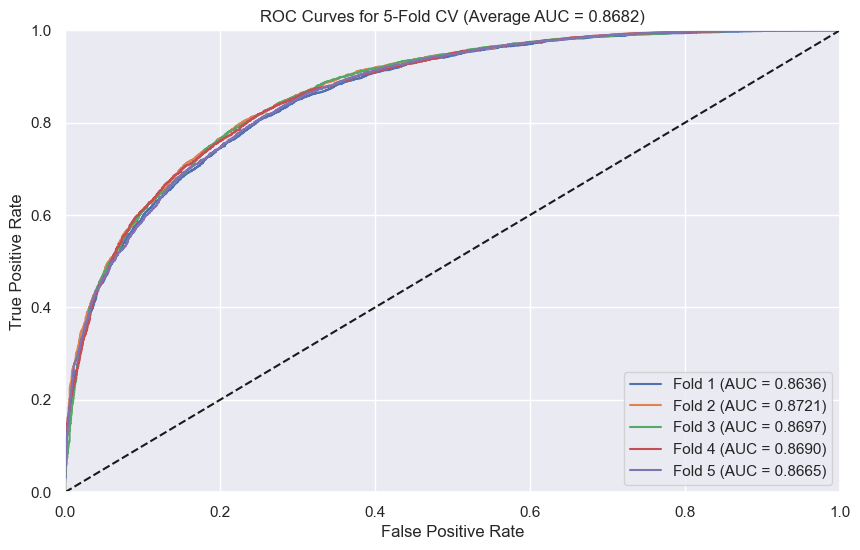

Average AUC across folds: 0.8682
AUC on Validation Set with Important Features: 0.8644


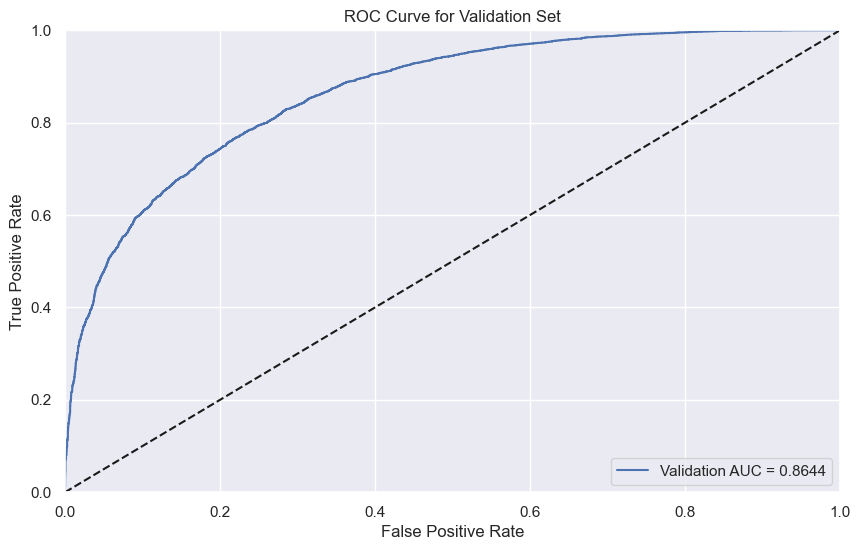

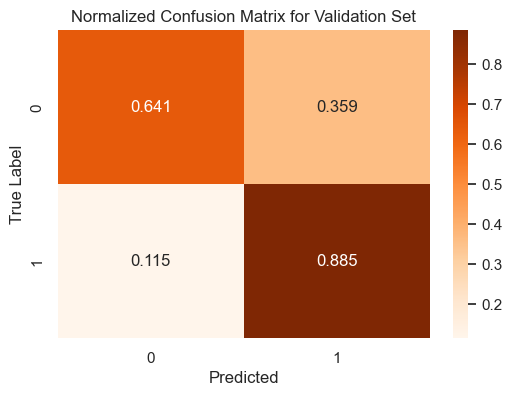

false negatives: 686
false positives: 1845


In [78]:

model_to_test= best_model(best_model_3, df_train_best_features, df_val_best_features)


PreProcess Train&Test

In [79]:
def pre_process_train(df):
    df = remove_rows_with_many_nulls(df)
    df,_ = categorical_cols_handle(df, True)
    df,_ = encode_catagorial_cols(df, True)
    df = numeric_cols_handle(df)
    df = boolean_cols_handle(df)
    filtered_numerical_cols = [col for col in numerical_cols if col != 'B_years_ratio']
    df = impute_missing_values(df, filtered_numerical_cols, binary_cols)
    df = winsorize_outliers_and_plot(df, 2)
    df = add_new_corr_feature(df, "B", "years_of_experience", "B_years_ratio", True, quantile_top=0.99, quantile_bottom=0.01)
    df = min_max_normalization(df, numerical_cols, df)
    return df


def pre_process_test(df):
    df,candidate_id = categorical_cols_handle(df, False)#False since it is not train
    df, _ = encode_catagorial_cols(df, train=False, continent_means=continent_means)
    df = numeric_cols_handle(df)
    df = boolean_cols_handle(df)
    filtered_numerical_cols = [col for col in numerical_cols if col != 'B_years_ratio']
    df = impute_missing_values(df, filtered_numerical_cols, binary_cols)
    df = winsorize_outliers_and_plot(df, 2)
    df = add_new_corr_feature(df, "B", "years_of_experience", "B_years_ratio", False, quantile_top=0.99, quantile_bottom=0.01)
    df = min_max_normalization(df, numerical_cols, df)
    return df, candidate_id





PIEPELINE

In [80]:
#Train Preprocess
train = pd.read_csv("train.csv")
train = pre_process_train(train)
label_train = train["label"]
train = train[important_features_3]
print("Done preprocess train")
#Test Preprocess
test = pd.read_csv("test.csv")
test, candidate_id = pre_process_test(test)
print("Done preprocess test")

test = test[important_features_3]
dum = model_to_test.fit(train,label_train)
predictions = model_to_test.predict_proba(test)[:,1]
predictions=pd.concat([candidate_id,pd.DataFrame(predictions)],axis=1)
predictions.columns=['candidate_id','predict_proba']
predictions.head()
predictions.to_csv('results_45.csv',index=False)




Number of rows to be removed: 3122
Done preprocess train
Done preprocess test


In [81]:
predictions

candidate_id  predict_proba
0             48786       0.130336
1             53074       0.103895
2             11758       0.816842
3             49289       0.940815
4             56787       0.788806
...             ...            ...
17995         47415       0.671949
17996         41780       0.172052
17997          2625       0.719124
17998          4019       0.118294
17999         22684       0.909098

[18000 rows x 2 columns]